# LCC Fungus 
## <font color = 'turquoise'> *Hyperspectral Study: Classification of hyperspectral images of fungal species based on machine learning* em python

  *Autor*: Adriel Lenner Vinhal Mori

  Link para o repositório Git
  - [Git - Fungus Classification](https://github.com/dvlucena/ht4m)
  - [Git - Adriel Mori](https://github.com/adrielmori/LCC_Fungus.git)
  - [Git Bactérias - Ricardo](https://github.com/artsousa/HyperSI)

Bibliografia e materiais
  - [Dimensionality Reduction on HSI](https://https://colab.research.google.com/drive/1Lstx55MxHT8bpXlgnaXYloVCmagE_xC7?usp=sharing#scrollTo=xjpDyNm3fKMt)

  - [Hyperspectral Image Analysis — Classification](https://towardsdatascience.com/hyperspectral-image-analysis-classification-c41f69ac447f)

## IMPORTS

In [1]:
import scipy.io
import numpy as np
import pandas as pdy

import h5py
import json

import os
import sys
import glob
# import earthpy as et
import spectral as sp
# import earthpy.spatial as es
# import earthpy.plot as ep
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from random import sample
from IPython.core.pylabtools import figsize

from mpl_toolkits import mplot3d
import numpy as np
from joblib import dump, load
import numpy.matlib
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
from sklearn.cluster import KMeans
import pickle
# from spectral import *

from math import factorial
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler

import pprint
import seaborn as sn

import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# import cv2

sp.settings.envi_support_nonlowercase_params = True

%matplotlib inline

c:\Users\Usuario\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## FUNCTIONS

In [2]:
import os
import pickle
import spectral as sp
from spectral import *

sp.settings.envi_support_nonlowercase_params = True


""" 
    Class Sample responsável por preparar os arquivos obtidos em Utils e gerar os hipercubos necessários. 
    Os arquivos gerados pela câmera (DARK, WHITE e .hdr) seguem a estrutura de arquivos dentro a "capture" e são 
    passados para o formato numpy.
 
 """

class Sample:
    def __init__(self, path, sample_name, inter='capture',
                 sample_prefix=None,
                 to_numpy_format=True):

        self.path = os.path.join(path, sample_name, (inter if inter else ''))
        self.sample_name = (sample_prefix if sample_prefix else '') + sample_name
        # print(self.path +'/'+ self.sample_name + '.hdr')


        self.image = None
        self.sample = None
        self.processed = None
        self.normalized = None
        self.sample_cluster = None
        
        self._read_image(to_numpy_format)

    def _read_image(self, to_numpy_format):
        """
            imagem armazena uma classe do pacote Spectral
            sample armazena um array numpy com 3 dimensões (comprimento de onda x linhas x colunas)
        """
        try:
            self.image = envi.open(os.path.join(self.path +'/'+ self.sample_name + '.hdr'))
            self.sample = self.image.load()

            if to_numpy_format:
                self.sample = self.sample.transpose(2, 0, 1)
                # print(self.sample)

        except Exception as e:
            print(e)

    def save(self):
        """
            salvar a imagem normalizada
        """
        sample_path = os.path.join(self.path, self.sample_name)
        sample_file = sample_path + '.pkl'

        with open(sample_file, 'wb') as destination_dir:
            pickle.dump(self, destination_dir, -1)

    @property
    def image(self):
        return self.__image

    @image.setter
    def image(self, var):
        self.__image = var

    @property
    def sample(self):
        return self.__sample

    @sample.setter
    def sample(self, var):
        self.__sample = var

    @property
    def normalized(self):
        return self.__normalized

    @normalized.setter
    def normalized(self, var):
        self.__normalized = var

    @property
    def processed(self):
        return self.__processed

    @processed.setter
    def processed(self, var):
        self.__processed = var

    @property
    def sample_cluster(self):
        return self.__sample_cluster

    @sample_cluster.setter
    def sample_cluster(self, var):
        self.__sample_cluster = var


# if __name__ == '__main__':
#     sample = Sample(folder_data, list(samples_dict.keys())[3])

#     print(sample.image.shape)
#     print('done')

In [3]:
def mean_from_3d(matrix: np.ndarray, ndims=2, axis=1):
    """
        Retornar o espectro médio da amostra 3D
        matriz: hipercubo (x, y, z)
        
        Parâmetros: 
            - matriz: A matriz em formato numpy
            - ndims: Número de dimensões
            - axis: O eixo da matriz x ao longo do qual o filtro deve ser aplicado
        Retorno
            - A média da matriz 3D
    """
    mean = np.mean(matrix, axis=axis).astype(np.float64)
    if ndims == 3:
        return mean.reshape((mean.shape[0], 1, mean.shape[1]))

    return mean

def raw2mat(image: Sample, white: Sample, dark: Sample, inplace=True):
    """
      Normaliza a amostra usando o Dark (0% Reflectance) e
      Referências brancas (100% de refletância), usando a equação:
      -log10((S - D)/(W - D))
      
      Parâmetros: 
          - image: A própria amostra sample, arquivo .hdr
          - white: Referência do branco, arquivo WHITEREF
          - dark: Referência do preto, arquivo DARKREF
          - inplace: significa altera o comportamento padrão, de modo que a operação no 
          dataframe não retorna nada, em vez disso, 'modifica os dados subjacentes'
          
      Funções: 
          extract_lines: Retorna somente as linhas obtidas na matrix
              - Parâmetros: A própria matriz e a quantidade de linhas. 
              - Retorno: Quantidade de linhas na matriz
          replace_median: Retorna matriz com a nova média substituída (verificando os locais na matriz em que são 
                          zero e substituindo pela próxima posição. 
              - Parâmetros: A própria matriz
              - Retorno: A matriz com valores substituidos da média
      Retorno: 
          - Matriz normalizada
    """
    def extract_lines(matrix, lines):
        rows = matrix.shape[1]
        return matrix[:, np.arange(0, rows, np.ceil(rows / lines)).astype(int), :]

    def replace_median(matrix):
        [_, rows, cols] = matrix.shape
        for z, x, y in zip(*np.where(matrix == 0)):
            if 0 < x < rows and 0 < y < cols:
                window = matrix[z, x - 1:x + 2, y - 1:y + 2]

                if len(np.where(window == 0)[0]) == 1:
                    matrix[z, x, y] = np.median(window[(window != 0)])

            return matrix

    extracted_dark = extract_lines(dark.sample, 25)
    extracted_white = extract_lines(white.sample, 25)

    raw_dark = mean_from_3d(matrix=extracted_dark, ndims=3, axis=1)
    raw_white = mean_from_3d(matrix=extracted_white, ndims=3, axis=1)
    raw_image = image.sample

    with np.errstate(divide='ignore', invalid='ignore'):
         pabs = np.nan_to_num(((raw_image - raw_dark) / (raw_white - raw_dark)), nan=0.0)

    normalized = replace_median(-np.log10((pabs * (pabs > 0)), where=(pabs > 0)))

    if inplace:
        image.normalized = normalized
        return

    return normalized

def normalized_raw(samples_dict, folder_data, folder_name=None):
    dict_cube={}
    gen_spc_name=[]
    for idx, sample in enumerate(list(samples_dict.keys())):
        # print(sample, idx)

        name_file=sample.split('_')
        name_sample='_'.join(name_file[:-1])
        gen_spc_name.append('_'.join((name_sample.split('_')[:2])))

        data_sample = Sample(folder_data, sample)
        darkref = Sample(folder_data, sample, sample_prefix='DARKREF_')
        whiteref = Sample(folder_data, sample, sample_prefix='WHITEREF_')

        data_sample.normalized = raw2mat(image=data_sample, dark=darkref, white=whiteref, inplace=False)
        
        ## Matrix to HSI Cube
        dict_cube[name_sample] = data_sample.normalized

        print('Done: ', name_sample, dict_cube[name_sample].shape)
    return dict_cube, gen_spc_name


def save_data_norm(data, dict, name_spc_file, path, folder):
    for idx, sample in enumerate(list(dict.keys())):
        # print(sample, idx)
        
        name_file=sample.split('_')
        name_sample='_'.join(name_file[:-1])
        
        # break
        
        if name_spc_file in name_sample :
            # print(name_sample, name_spc_file)
            sample_path = os.path.join(folder+path, name_sample)
            print(sample_path)
            
            if os.path.isfile(sample_path + f'/{name_sample}.pkl'):
                print(f"{name_sample} normalized and save")
                continue

            os.makedirs(sample_path, exist_ok=True)
            sample_file = sample_path + f'/{name_sample}.pkl'
        
            with open(sample_file, 'wb') as destination_dir:
                pickle.dump(data[name_sample], destination_dir, -1)
                
            print('Done: ', name_sample)
            
        else:
            continue

In [4]:
#Create a matrix of indices, according to the idx and rmv of the sample
def rev_idx_array(idx, rmv, shape=None, tfill=None):
    if shape is None:
        out = np.zeros(idx.shape[0] + rmv.shape[0])
    else:
        out = np.zeros(shape)

    out[rmv] = 0

    if tfill is not None:
        for i, row in enumerate(idx):
            out[row] = tfill[i]
    else:
        out[idx] = 1

    return out.astype(int)

#
def sum_idx_array(idx):
      ind_r = []
      for i, (j, ind) in enumerate(zip(idx, np.arange(idx.shape[0]))):
          if j != ind or j==0:
              ind_r.append(i)
      return np.delete(idx, ind_r), np.array(ind_r)
#
#Retorna o rotulo de cada pixel ao seu correpondente clustercluster
#É executado empregando as classes com os algoritmos PCA e K-means

def hsiRemoveBackground(key, X = None, PCS = None): 
    if 'Fungo' in key:
       aux_cube=hsi2matrix(X)
    else: 
       aux_cube=hsi2matrix(X)[:,100:220]

    scores = PCA(n_components=PCS).fit_transform(aux_cube)
    # 'n_components()'Número de componentes a serem mantidos.
    #se n_components não estiver definido, todos os componentes serão mantidos

    # 'fit_transform()' Ajusta o modelo com X e aplique a redução de dimensionalidade em X.

    #Retorna a matriz com a remoção do fundo
    return KMeans(n_clusters=2, init='k-means++', n_init=5, max_iter=300).fit(scores).labels_

#
def hex2rgb(value):
  return tuple(int(value.lstrip('#')[i:i + 2], 16) for i in (0, 2, 4))

#
def realIdx(idx, c):
      out = np.arange(idx.shape[0])
      for idx, (rid, vec) in enumerate(zip(out, idx)):
          if vec != c:
              out[idx] = -1
      out[out == -1] = 0
      # print(out)

      return out

#
def hsi2matrix(matrix: np.ndarray):
  return matrix.T.reshape((matrix.shape[1] * matrix.shape[2], matrix.shape[0]), order='F')

#
def rgbscale(image):
  return (image * 255).astype(np.uint8)

#
def getClusters(image = None,INDEX = None, c = None, rgb = None):
      ind = realIdx(INDEX, c)
      out_i = np.concatenate((ind, ind, ind), axis=0).reshape((3, *(image.shape[:2])))

      if len(image.shape) == 2:
          image = MinMaxScaler(feature_range=(0, 1)).fit_transform(image)
          image = np.stack((image, image, image), axis=2)

      image[out_i[0] != 0, 0] = rgb[0]
      image[out_i[1] != 0, 1] = rgb[1]
      image[out_i[2] != 0, 2] = rgb[2]

      return image

#Moving the matrix axes to work with the bands
def moveAxis(data):
  data = np.moveaxis(data, 2, 0)
  # ep.plot_rgb(data, title='Visualizando amostra', figsize=(8, 4))
  # plt.show()

  return data

#
def plot_clusters(out_i, out_i2, key, tam):
      
    if tam>300:
        fig = plt.figure(figsize=(9, 9))
    if tam<300:
        fig = plt.figure(figsize=(9, 6))

    rows = 1
    columns = 2
    
    fig = plt.figure(figsize=(14, 6))
    fig.add_subplot(rows, columns, 1)
    plt.imshow(out_i)
    # plt.axis('off')
    plt.title("1")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(out_i2)
    # plt.axis('off')
    plt.title("2")
    plt.suptitle(key, fontsize=20)
    plt.show()

    # fig.add_subplot(rows, columns, 3)
    # plt.imshow(out_i3)
    # plt.title("3")
    # plt.suptitle(key, fontsize=20)
    # plt.show()

    # fig.add_subplot(rows, columns, 4)
    # plt.imshow(out_i4)
    # plt.title("4")
    # plt.suptitle(key, fontsize=20)
    # plt.show()

#Processing the sampled image in HSI resulting in images processed in RGB from the
#species of banana
def hsiImageProcess(DATA = None): 
    list_inds = {}
    list_sample_clusters = {}
    list_rm = {}

    for key in DATA.keys():
        # print(DATA[key].shape, '----->', key)

        CUBE = DATA[key]
        # CUBE = moveAxis(CUBE)
        INDEX = hsiRemoveBackground(key, CUBE, 2) + 1
        image = CUBE[200,:,:]

        out_i = getClusters(image, INDEX, 1, (1, 0, 0))
        out_i2 = getClusters(image, INDEX, 2, (0, 1, 0))
        # out_i3 = getClusters(image, INDEX, 3, (0, 0, 1))
        # out_i4 = getClusters(image, INDEX, 4, (1, 0, 1))

        fig = plt.figure(figsize=(7, 7))

        tam=len(CUBE[:][:][0])
        plot_clusters(out_i,out_i2, key, tam)
        # break

        cluster = input('Is the cluster of interest red-1 or green-2?\n')
        line = '_'
        print(line*140, '\n')

        list_inds[key], list_rm[key] = sum_idx_array(realIdx(INDEX, int(cluster)))

        #Apply values ​​of 0 and 1 to differentiate label and background
        list_sample_clusters[key] = rev_idx_array(list_inds[key], list_rm[key])

        out_i_result = getClusters(image, list_sample_clusters[key], 1, (1, 0, 0))
        plt.imshow(out_i_result)
        plt.show()
        print(list_inds[key], list_rm[key].shape, list_sample_clusters[key].shape)

    return list_inds, list_sample_clusters

In [5]:
def snv(matrix: np.array):
    """
      Standard Normal Variate (SNV). 
      
      Parâmetros: 
          - matrix: Matriz em formato numpy
      Retorno: 
          - Matriz normalizada conforme SNV
    """
    out = np.zeros_like(matrix)
    for i in range(matrix.shape[0]):
       out[i, :] = (matrix[i, :] - np.mean(matrix[i, :])) / np.std(matrix[i, :])
    return out


def sgolay(matrix: np.ndarray, order=2, window=21, derivative=1, mode='wrap'):
    """
        Savitzky-Golay filter
    """
    return savgol_filter(matrix, window, order, deriv=derivative, mode=mode)

def hsi2matrix(matrix: np.ndarray):
      """ 
          Reorganizar a matriz 3D para que cada pixel se torne um
          linha na matriz retornada 2D
          
          Parâmetros: 
              - matriz: Hipercubo em formato numpy
          Retorno: 
              - Matriz convertida em bidimensional
      """
      return matrix.T.reshape((matrix.shape[1] * matrix.shape[2], matrix.shape[0]), order='F')

def normalize_mean(matrix: np.ndarray):
      """
        Centralizar os dados em 0 com a média
        
        Parâmetros: 
            - matrix: Matriz com formato numpy
        Retorno: 
            - Matriz normalizada
      """

      out = np.zeros_like(matrix)
      for i in range(matrix.shape[0]):
          out[i, :] = (matrix[i, :] - np.mean(matrix[i, :]))

      return out

def _signal_filter(sample, golay: bool, SNV: bool, order=2, window=21, dv=1, mode='constant'):
        
      """ 
        A função "_signal_filter" aplica o métodos para filtrar, normalizar e suavizar as imagens.
        
          Parâmetros: 
              - Sample: amostras das bactérias.
            
          Retorno: 
              - Matrix filtrada. 
      """

      # print(sample.shape,type(sample))
      matrix = hsi2matrix(sample)
      matrix = normalize_mean(matrix)
      if SNV == True:
            matrix = snv(matrix=matrix)
      if golay == True:
           matrix = sgolay(matrix=matrix, order=order, window=window, derivative=dv, mode=mode)

      return matrix

In [6]:
def save_dict(dict, name_file):
    with open(name_file, "wb") as tf:
       pickle.dump(dict,tf)

def load_dict(name_file):
  scores = {} # scores is an empty dict already

  if os.path.getsize(name_file) > 0:      
      with open(name_file, "rb") as f:
          unpickler = pickle.Unpickler(f)
          # if file is not empty scores will be equal
          # to the value unpickled
          scores = unpickler.load()
  return scores

def load_pkl(folder_list, folder_samples, data_folder, golay: bool, snv: bool):
    list_dict=[]
    for i in range(len(folder_samples)):    
       list_dict.append({})
  
    for temp in folder_list:
        for paths in glob.glob(temp+data_folder):
            for diretorio, subpastas, arquivos in os.walk(paths):
                for file in arquivos:  
                    if file.lower().endswith(".pkl"):
                        dest=diretorio+'/'+ file
                        file=file.split('.')[0]
                        
                        for i in range(len(folder_samples)):
                            if folder_samples[i] in file:
                                print(dest)
                                with open(dest, 'rb') as f:
                                    list_dict[i][file] = pickle.load(f)
                                    
                                    matrix=_signal_filter(list_dict[i][file], golay, snv)
                                    rows, cols = list_dict[i][file].shape[1:]
                                    
                                    ## Matrix to HSI Cube
                                    list_dict[i][file] = matrix.T.reshape(-1, rows, cols)
    
    return list_dict

## PREPROCESSING OF HYPERSPECTRAL CAPTURES


### Image Process (White and Dark references) and save

In [ ]:
# folder='C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/'
folder='C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/'
folder_datas=folder+'data/'
samples_dict ={}
fungus_dict ={}

cont=0
for paths in glob.glob(folder_datas+'*/capture/'):
  for diretorio, subpastas, arquivos in os.walk(paths):
    list_sample=[]
    name_file=diretorio.split('\\')[1]
    # name_file=diretorio.split('/')[-3]
    # line1='_'.join(name_file)
    if  len(arquivos) < 6: #for incomplete samples
      print(arquivos)
      continue
    else:
      for arquivo in arquivos:
        if arquivo.lower().endswith(".hdr"):
          dest=diretorio+arquivo
          list_sample.append(dest)
          
    if 'Meio' in name_file or 'Fungo' in name_file:
      fungus_dict[name_file] = list_sample
    else:
      samples_dict[name_file] = list_sample

# fungus_data=normalized_raw(fungus_dict)
samples_data, folder_samples=normalized_raw(samples_dict, folder_datas) 

#generating species list
folder_samples =list(dict.fromkeys(folder_samples))


## Saving normalized data per species folders 
for i in folder_samples:
    save_data_norm(samples_data, samples_dict, i, f'data_process_raw/{i}/', folder)

### Clusters Select with Golay and SNV

In [21]:
folder='C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/'
folder_2='C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/'
data_folder='data_process_raw'
list_fl=[folder]

folder_samples=[]
for folder in list_fl:
    aux=glob.glob(folder+data_folder+'/*')
    for i in aux:
        file=i.split('\\')[-1]
        folder_samples.append(file)

data_dicts=[]
data_dicts=load_pkl(list_fl , folder_samples, data_folder, golay=True, snv=True)

C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/data_process_raw\Aspergillus_niger\Aspergillus_niger_14d/Aspergillus_niger_14d.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/data_process_raw\Aspergillus_niger\Aspergillus_niger_30d/Aspergillus_niger_30d.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/data_process_raw\Aspergillus_niger\Aspergillus_niger_48h/Aspergillus_niger_48h.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/data_process_raw\Aspergillus_niger\Aspergillus_niger_96h/Aspergillus_niger_96h.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/data_process_raw\Aspergillus_terreus\Aspergillus_terreus_14d/Aspergillus_terreus_14d.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/data_process_raw\Aspergillus_terreus\Aspergillus_terreus_30d/Aspergillus_terreus_30d.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/data_process_raw\Aspergillus_terreus\Aspergillus_terreus_48h/Aspergillus_terr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

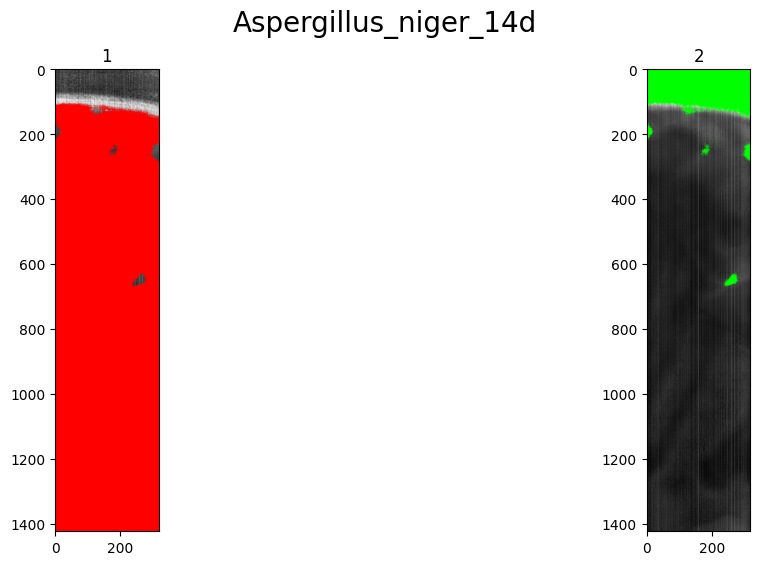

____________________________________________________________________________________________________________________________________________ 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


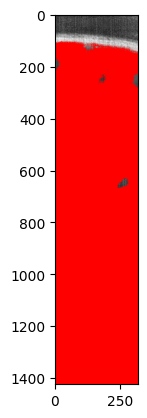

[ 30115  30153  30173 ... 455677 455678 455679] (41844,) (455680,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

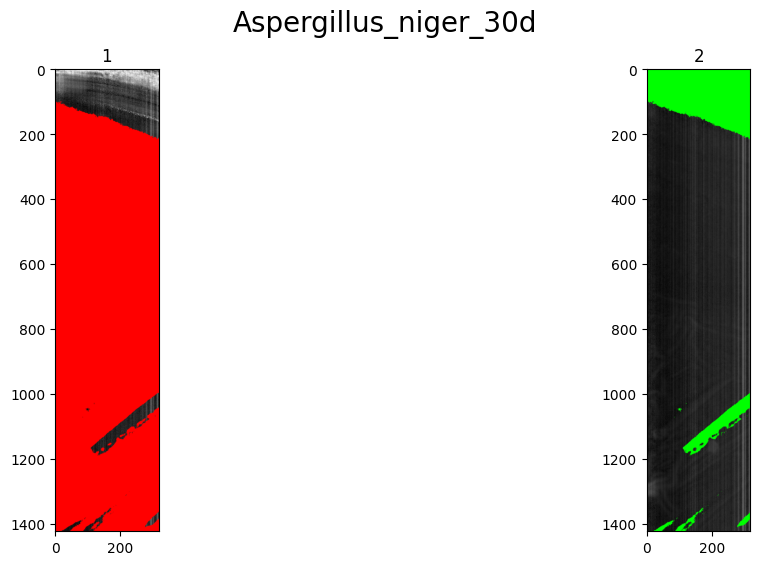

____________________________________________________________________________________________________________________________________________ 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


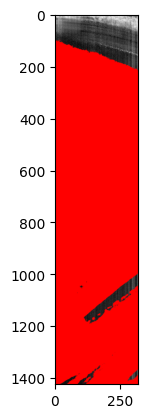

[ 31697  31698  31699 ... 455677 455678 455679] (61827,) (455680,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

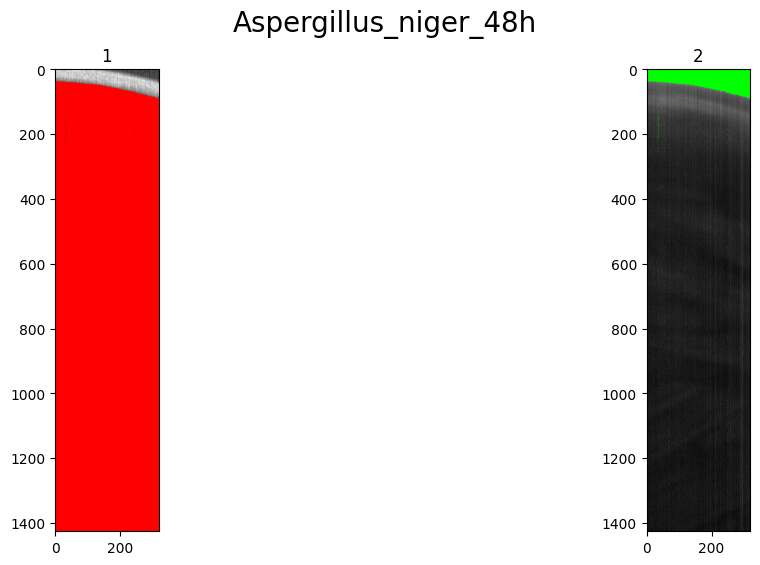

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


____________________________________________________________________________________________________________________________________________ 



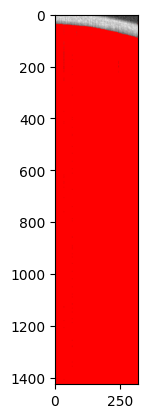

[  2963  11518  11846 ... 456317 456318 456319] (18604,) (456320,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

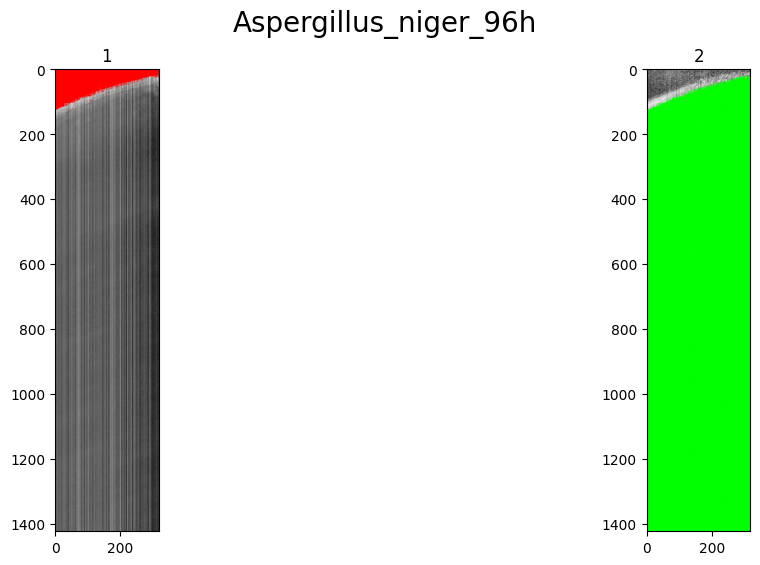

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


____________________________________________________________________________________________________________________________________________ 



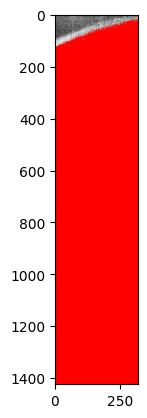

[  6396   6398   6399 ... 455677 455678 455679] (21183,) (455680,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

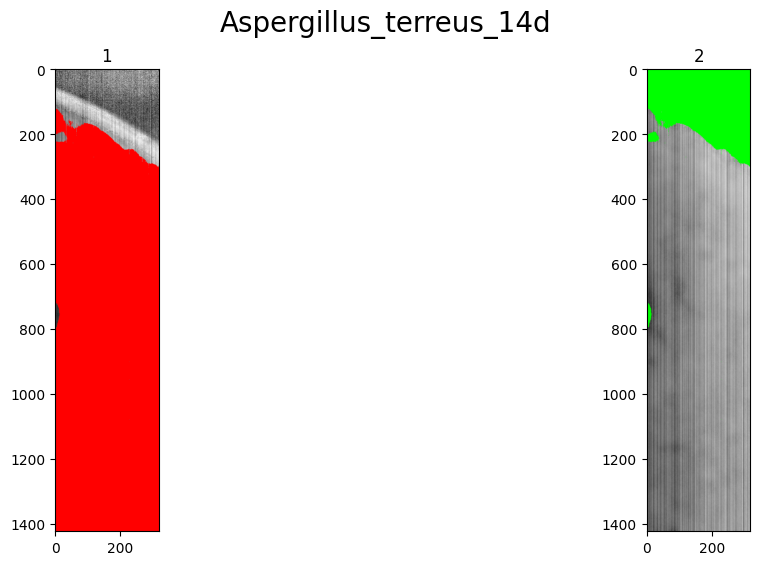

____________________________________________________________________________________________________________________________________________ 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


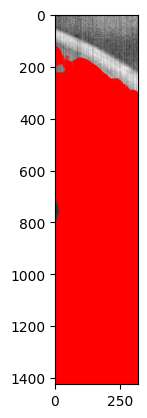

[ 39040  39042  39360 ... 455677 455678 455679] (69760,) (455680,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

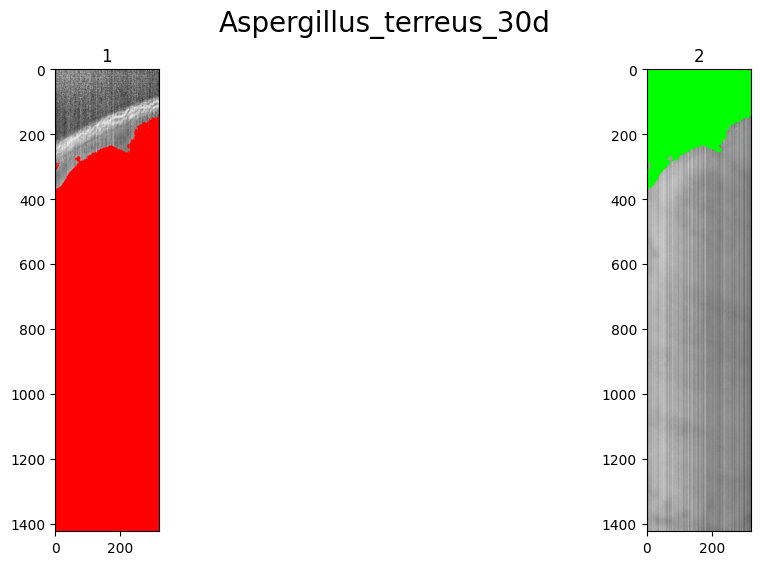

____________________________________________________________________________________________________________________________________________ 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


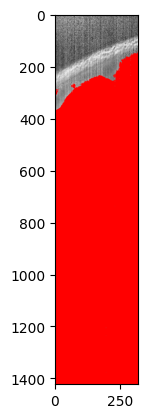

[ 45431  46075  46394 ... 455357 455358 455359] (79307,) (455360,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

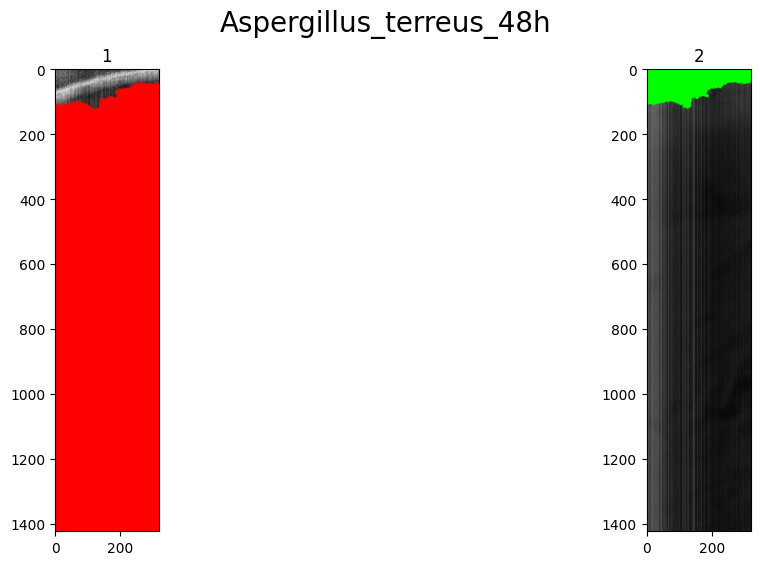

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


____________________________________________________________________________________________________________________________________________ 



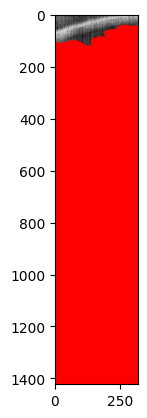

[ 12478  12798  13060 ... 455357 455358 455359] (25878,) (455360,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

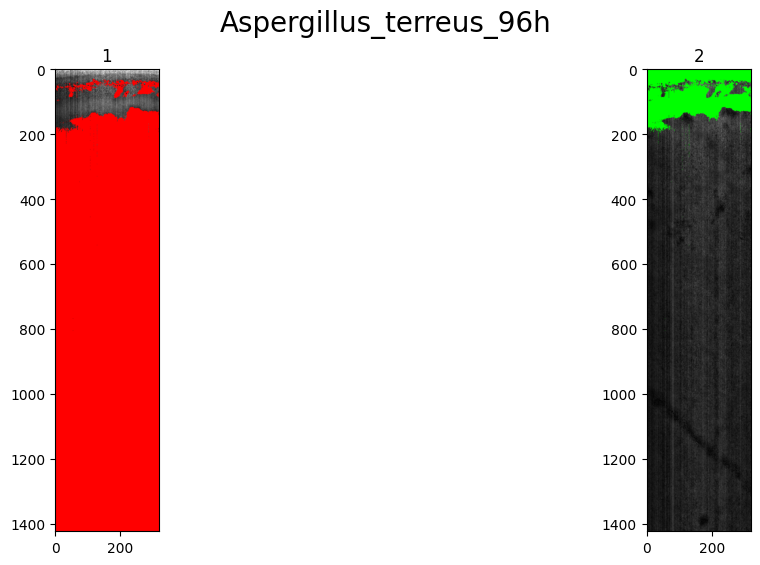

____________________________________________________________________________________________________________________________________________ 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


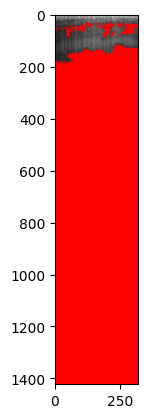

[  9717   9718   9719 ... 455357 455358 455359] (41378,) (455360,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

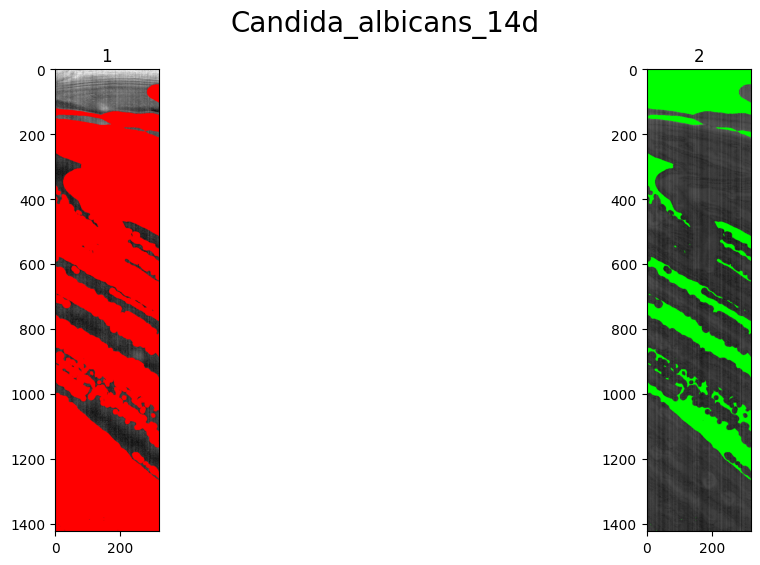

____________________________________________________________________________________________________________________________________________ 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


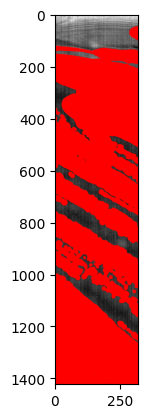

[ 15350  15351  15352 ... 455357 455358 455359] (112417,) (455360,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

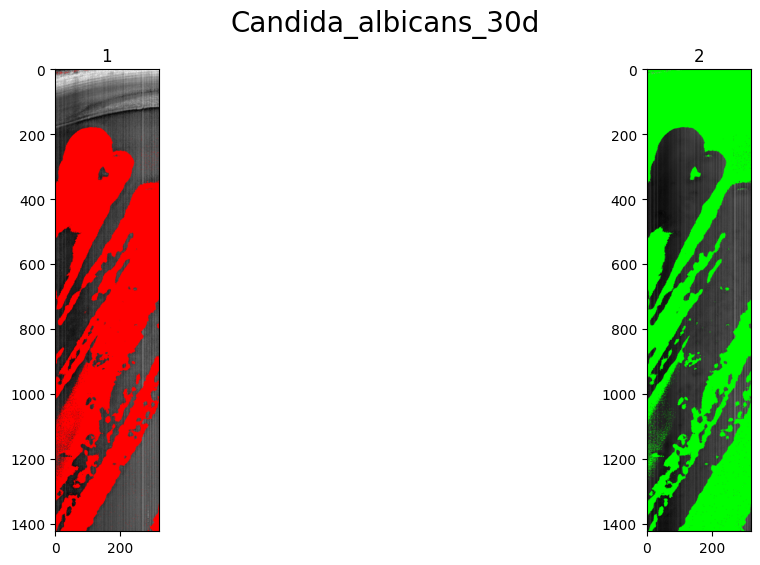

____________________________________________________________________________________________________________________________________________ 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


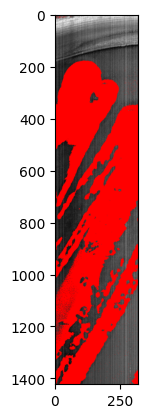

[   732    735   1022 ... 455356 455357 455359] (222161,) (455360,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

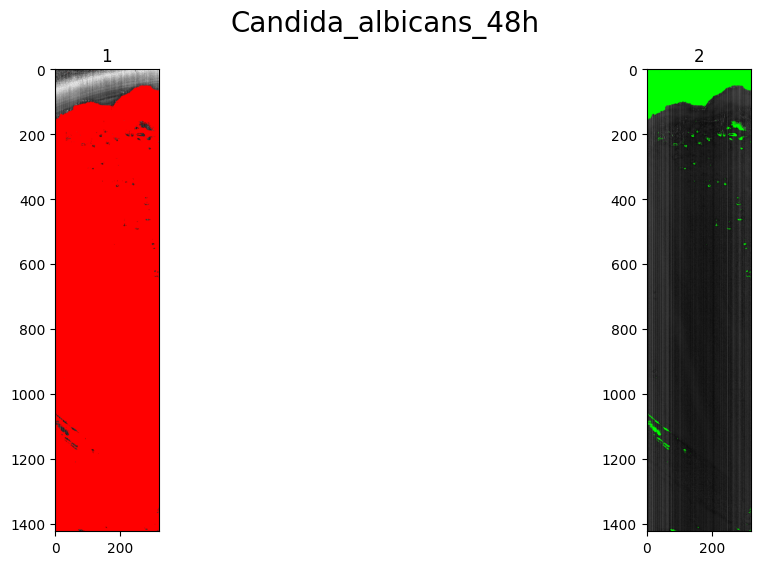

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


____________________________________________________________________________________________________________________________________________ 



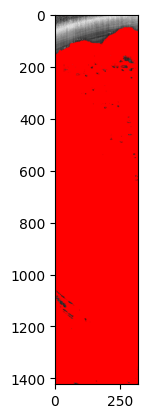

[   119    747   1399 ... 455352 455353 455358] (33746,) (455360,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

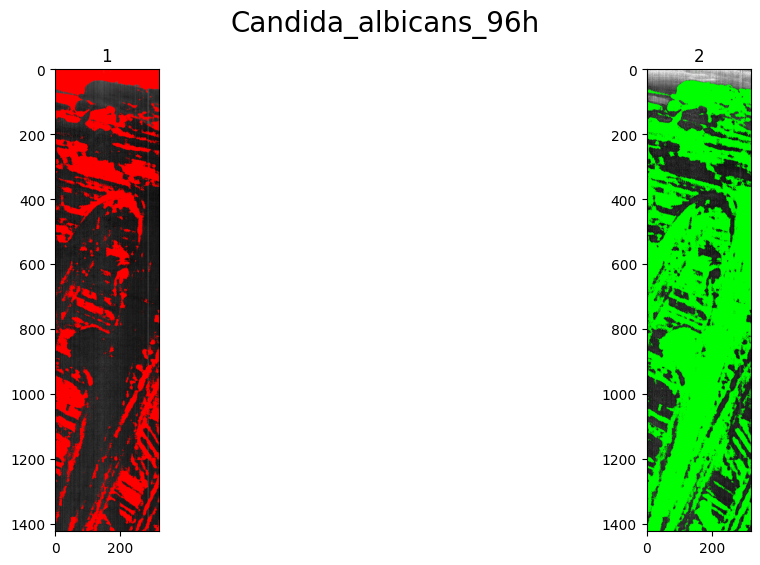

____________________________________________________________________________________________________________________________________________ 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


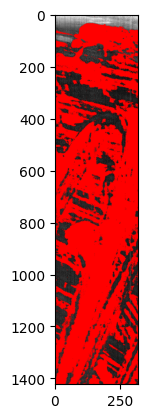

[  1110   1430   2390 ... 455344 455345 455346] (148243,) (455360,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

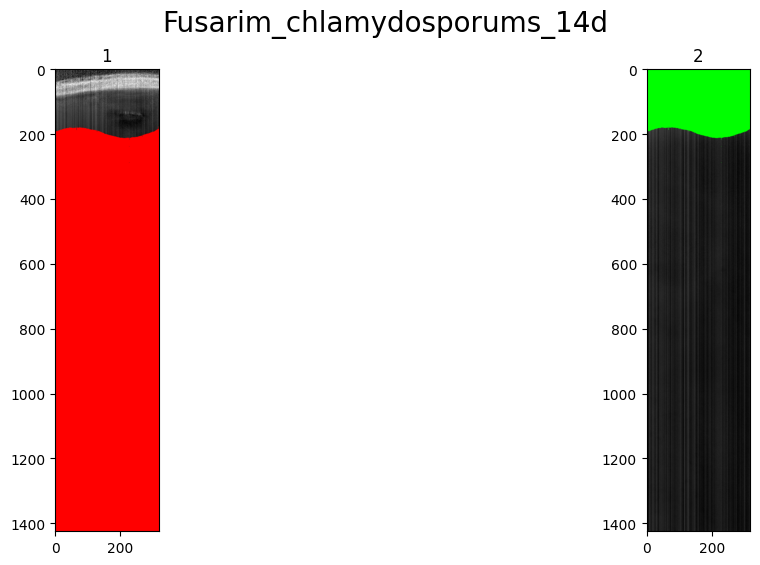

____________________________________________________________________________________________________________________________________________ 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


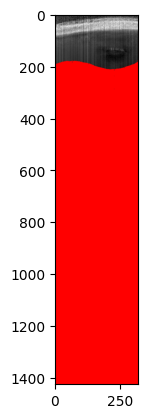

[ 56958  57027  57278 ... 455997 455998 455999] (62602,) (456000,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

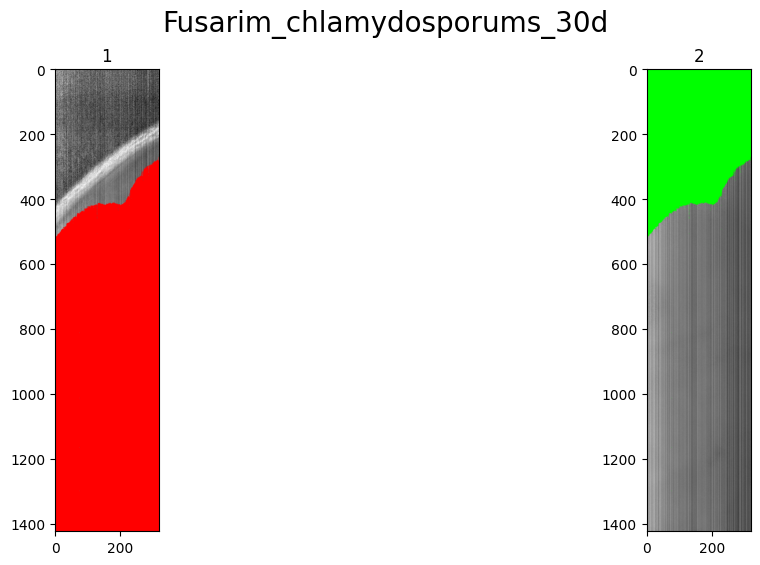

____________________________________________________________________________________________________________________________________________ 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


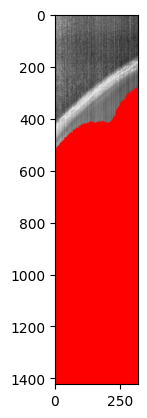

[ 87038  87358  87678 ... 455357 455358 455359] (129222,) (455360,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

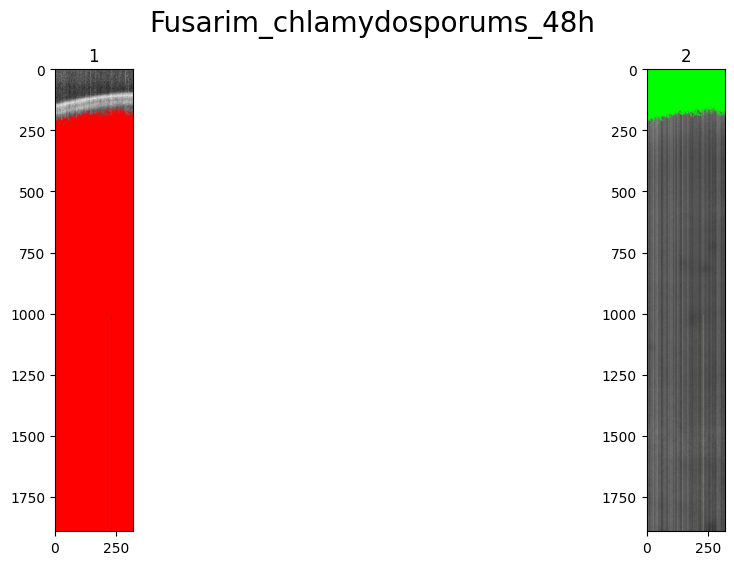

____________________________________________________________________________________________________________________________________________ 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


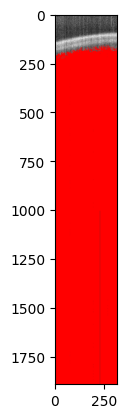

[ 49852  49874  49900 ... 605437 605438 605439] (60419,) (605440,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

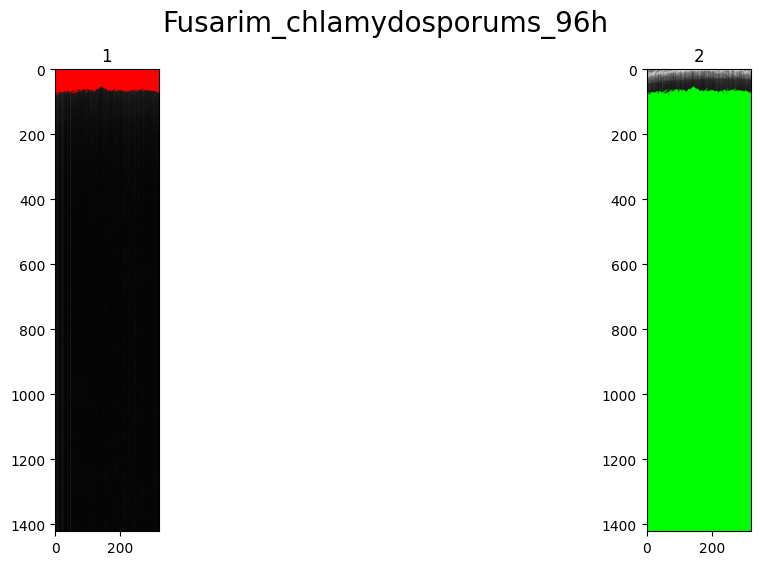

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


____________________________________________________________________________________________________________________________________________ 



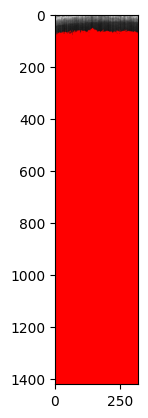

[ 17102  17421  17422 ... 455037 455038 455039] (21345,) (455040,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

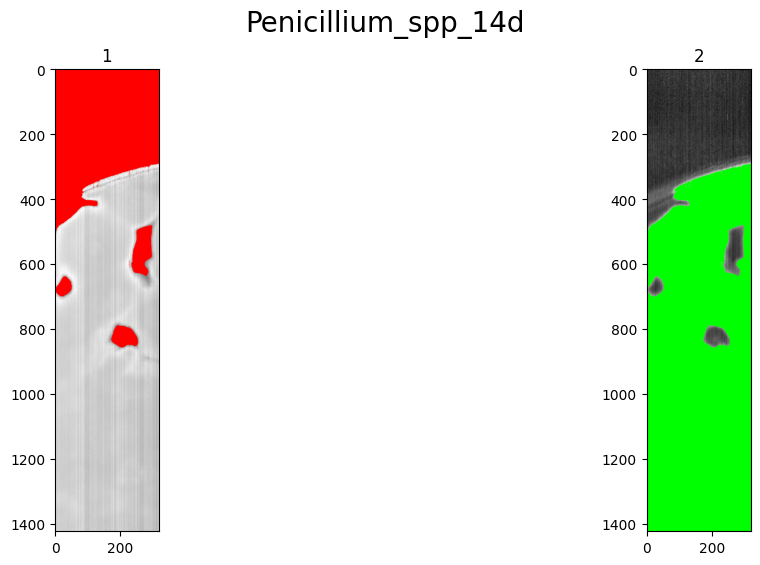

____________________________________________________________________________________________________________________________________________ 



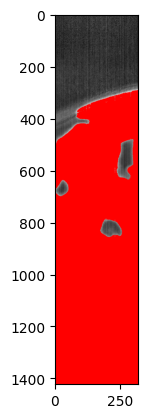

[ 93754  93755  93756 ... 455357 455358 455359] (129331,) (455360,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

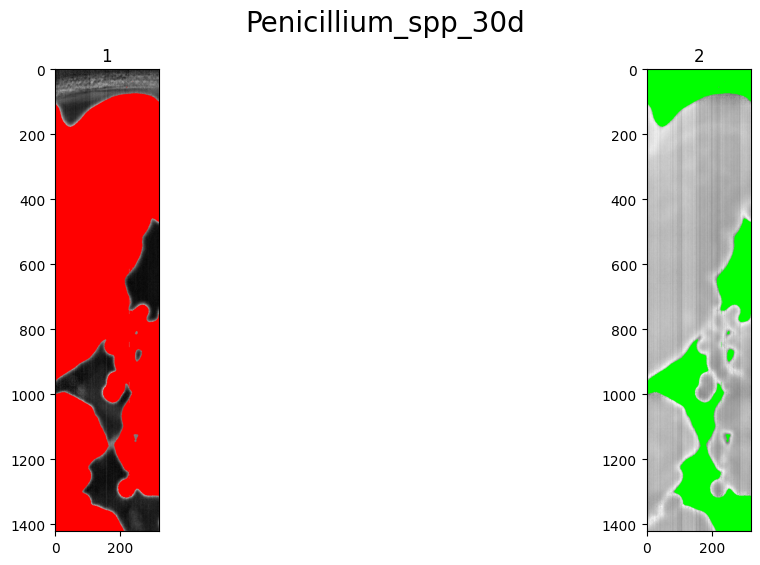

____________________________________________________________________________________________________________________________________________ 



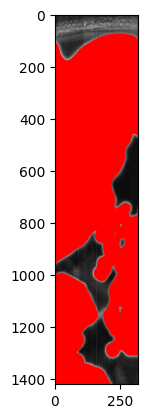

[ 12398  17501  17820 ... 454930 454931 454932] (116397,) (455040,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

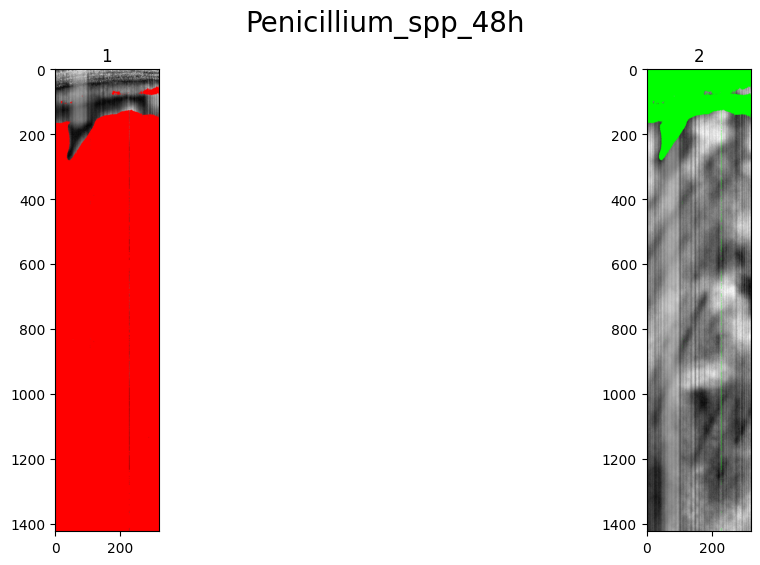

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


____________________________________________________________________________________________________________________________________________ 



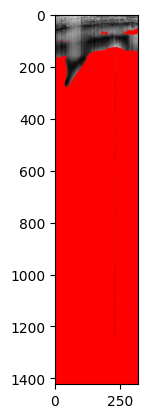

[ 16638  16958  17278 ... 455357 455358 455359] (52800,) (455360,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 700x700 with 0 Axes>

<Figure size 900x900 with 0 Axes>

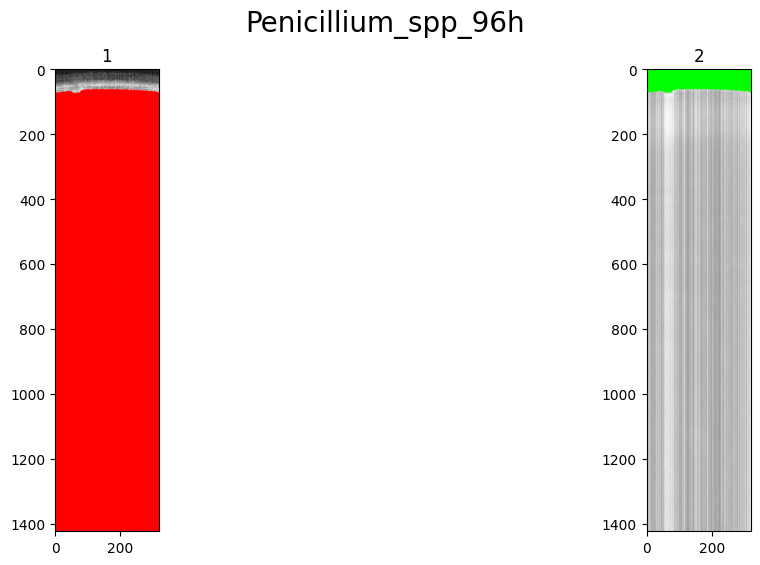

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


____________________________________________________________________________________________________________________________________________ 



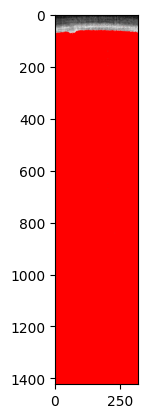

[ 13938  14180  14556 ... 455357 455358 455359] (21027,) (455360,)


In [22]:
dict_info={}
for i,name in enumerate(folder_samples):
    samples_list_inds, samples_list_clusters = hsiImageProcess(data_dicts[i])

    dict_info[name]= {
                    'ind_': samples_list_inds,
                    'cluster_': samples_list_clusters
                     }
    
save_dict(dict_info, folder+"dict_list_clusters.pkl")

### Select proposed Filters for Data preparation

In [43]:
# ---- Raw images load for aplications filter for training ----

folder='C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/'
folder_2='C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/' 
data_folder='data_process_raw'
list_fl=[folder]

In [44]:
dict_info=load_dict(folder+"dict_list_clusters.pkl")
dict_info.keys()

dict_keys(['Aspergillus_niger', 'Aspergillus_terreus', 'Candida_albicans', 'Fusarim_chlamydosporums', 'Penicillium_spp'])

In [9]:
folder_samples=[]
for folder in list_fl:
    aux=glob.glob(folder+data_folder+'/*')
    for i in aux:
        file=i.split('\\')[-1]
        folder_samples.append(file)

data_dicts=[]
data_dicts=load_pkl(list_fl , folder_samples, data_folder, golay=False, snv=False)

for i, sample_class in enumerate(data_dicts):
    x=list(sample_class.keys())
    fir=x[0].split('_')[0]
    sec=x[0].split('_')[1]
    conc=[fir, sec]
    variable_name=('_').join(conc)
    if 'Fungo' in variable_name:
        variable_name= 'Manisopliae'
    # print(variable_name)
    key='data_'
    dict_info[variable_name][key]= data_dicts[i]

C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/data_process_raw\Aspergillus_niger\Aspergillus_niger_14d/Aspergillus_niger_14d.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/data_process_raw\Aspergillus_niger\Aspergillus_niger_30d/Aspergillus_niger_30d.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/data_process_raw\Aspergillus_niger\Aspergillus_niger_48h/Aspergillus_niger_48h.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/data_process_raw\Aspergillus_niger\Aspergillus_niger_96h/Aspergillus_niger_96h.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/data_process_raw\Aspergillus_terreus\Aspergillus_terreus_14d/Aspergillus_terreus_14d.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/data_process_raw\Aspergillus_terreus\Aspergillus_terreus_30d/Aspergillus_terreus_30d.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/data_process_raw\Aspergillus_terreus\Aspergillus_terreus_48h/Aspergillus_terr

In [ ]:
# def visualizate_clusters(tittle, sample_cluster, image, cut=None):

# #   image = moveAxis(image)
#   image=image[210,:,:]
#   out_i = getClusters(image, sample_cluster, 0, (1, 1, 1))
#   plt.title(tittle)
#   plt.imshow(rgbscale(out_i))
#   plt.axis()
#   plt.show()
#   print('\n')
  
# for key in fungus_data.keys():
#   visualizate_clusters(key, fungus_list_clusters[key], 
#                       fungus_data[key])

# for key in samples_data.keys():
#   visualizate_clusters(key, samples_list_clusters[key], 
#                       samples_data[key])

### Working with Subsampling

In [10]:
import cv2

Crop_range=[723, 1223]
fungus_crop={
            'Aspergillus_niger_14d': Crop_range,
            'Aspergillus_niger_30d': Crop_range,
            'Aspergillus_niger_48h': Crop_range,
            'Aspergillus_niger_96h': Crop_range,
            'Aspergillus_terreus_14d': Crop_range,
            'Aspergillus_terreus_30d': Crop_range,
            'Aspergillus_terreus_48h': Crop_range,
            'Aspergillus_terreus_96h': Crop_range,
            'Candida_albicans_14d': Crop_range,
            'Candida_albicans_30d': Crop_range,
            'Candida_albicans_48h': Crop_range,
            'Candida_albicans_96h': Crop_range,
            'Fusarim_chlamydosporums_14d': Crop_range,
            'Fusarim_chlamydosporums_30d': Crop_range,
            'Fusarim_chlamydosporums_48h': Crop_range,
            'Fusarim_chlamydosporums_96h': Crop_range,
            'Penicillium_spp_14d': Crop_range,
            'Penicillium_spp_30d': Crop_range,
            'Penicillium_spp_48h': Crop_range,
            'Penicillium_spp_96h': Crop_range,
            }

CropF_range_list=[1800, 2300]
dict_cut={
          'Rmicroplus_Controle_Zero_1': [1300, 1800],
          'Rmicroplus_Controle_Zero_2': [1500, 2000],
          'Rmicroplus_Controle_TweenImersao_1': [1600, 2100],
          'Rmicroplus_Controle_TweenImersao_2': [1200, 1700],
          'Rmicroplus_Controle_TweenInjecao_1': [1500, 2000],
          'Rmicroplus_Controle_TweenInjecao_2': [1400, 2000],
          'Rmicroplus_Imersao_12h_1': [1500, 1900],
          'Rmicroplus_Imersao_12h_2':[1400, 1900],
          'Rmicroplus_Imersao_24h_1':[1500, 1900],
          'Rmicroplus_Imersao_24h_2':[1300, 1900],
          'Rmicroplus_Imersao_24h_3':[1400, 1900],
          'Rmicroplus_Injecao_12h_1':[1300, 1800],
          'Rmicroplus_Injecao_6h_2':[1500, 1900],
          'Rmicroplus_Injecao_6h_1':[1600, 2000],
}
fungus_dict_cut={
          'Fungo_Manisopliae_IP119_1': CropF_range_list, 
          'Fungo_Manisopliae_IP119_1_OutraRegiaoDaPlaca': CropF_range_list, 
          'Fungo_Manisopliae_IP119_2_1': CropF_range_list, 
          'Fungo_Manisopliae_IP119_2_2': CropF_range_list, 
          'Fungo_Manisopliae_IP119_2_3': CropF_range_list, 
        #   'Meio_BDAY', 
        #   'Meio_BDAY_Maior'
}

# for i, key in enumerate(dict_cut):
#     name_file=key.split('_')
#     name_sample='_'.join(name_file)
    
#     samples_data[key]=hsi_crop(samples_data[key], dict_cut[key])
#     print(samples_data[key].shape)
#     plt.imshow(rgbscale(samples_data[key][200,:,:]))
#     plt.axis()
#     plt.show()
#     print('\n')

In [41]:
def hsi_crop_test(CUBE, cluster, cut, sample, view, x, w,):
    
    if view==True:
        #clipping the hypercube according to the height-axis coordinates
        cut_cube = CUBE[w[0]:w[1], 0:(CUBE.shape[1]), x[0]:x[1] + (w[1]-w[0])]
            
        ind, rem = sum_idx_array(realIdx(cluster, 1))
        real_inds_plot = rev_idx_array(ind, rem)
        
        plotimg=getClusters(cut_cube[200,:,:], real_inds_plot, 0, (0,1,0))
        plotimg2=getClusters(cut_cube[200,:,:], real_inds_plot, 1, (1,0,0))
        
        fig = plt.figure(figsize=(14, 6))
        fig.add_subplot(1, 2, 1)
        plt.imshow(plotimg)
        fig.add_subplot(1, 2, 2)
        plt.imshow(plotimg2)
        plt.suptitle(sample)
        plt.show()
        
        print(sample, ' :', cut_cube.shape)
        
    return cut_cube


def hsi_crop(CUBE, ind, cluster, cut, sample, task, view: bool, x=[0,320], w = [5, 235]):
    
    # Set global debug behavior to None (default), "print" (to file), 
    # or "plot" (Jupyter Notebooks or X11)
    
    ref_img = CUBE[[0], :, :]
    ref_img = np.transpose(np.transpose(ref_img)[0])
    # cropped = img[:, y:y + h, x:x + w]
    
    ## Test samples selection
    if len(task) > 0:
        return hsi_crop_test(CUBE, cluster, [1, CUBE.shape[1]], sample, view, x, w), ind, cluster
    
    #clipping the hypercube according to the height-axis coordinates
    cut_cube = CUBE[w[0]:w[1], cut[0]:cut[1], x[0]:x[1] + (w[1]-w[0])]
    
    #completing the ind of samples pixels
    ind, rem = sum_idx_array(realIdx(cluster, 1))
    real_inds = rev_idx_array(ind, rem, tfill=ind)
    
    ## Setting initial and final pixel according to the cut
    inicio=cut[0]*x[1]
    step=cluster.shape[0]-(cut[1]*x[1])
    fim=cluster.shape[0]-step  
    
    #Compenetns pixles selection of the accoding cut
    real_inds=real_inds[inicio:fim]
    real_cluster=cluster[inicio:fim]
    
    if view==True:
        real_inds_plot = rev_idx_array(ind, rem)
        real_inds_plot=real_inds_plot[inicio:fim]
        
        plotimg=getClusters(cut_cube[200,:,:], real_inds_plot, 0, (0,1,0))
        plotimg2=getClusters(cut_cube[200,:,:], real_inds_plot, 1, (1,0,0))
        
        fig = plt.figure(figsize=(14, 6))
        fig.add_subplot(1, 2, 1)
        plt.imshow(plotimg)
        fig.add_subplot(1, 2, 2)
        plt.imshow(plotimg2)
        plt.suptitle(sample)
        plt.show()
    
    ## ind remaked for subsample
    new_array=np.array([i for i in real_inds if i != 0])
    
    print(sample, ' :', cut_cube.shape)
    
    return cut_cube, new_array, real_cluster

In [12]:
dict_info['Candida_albicans']['data_']['Candida_albicans_48h'].shape

(256, 1423, 320)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


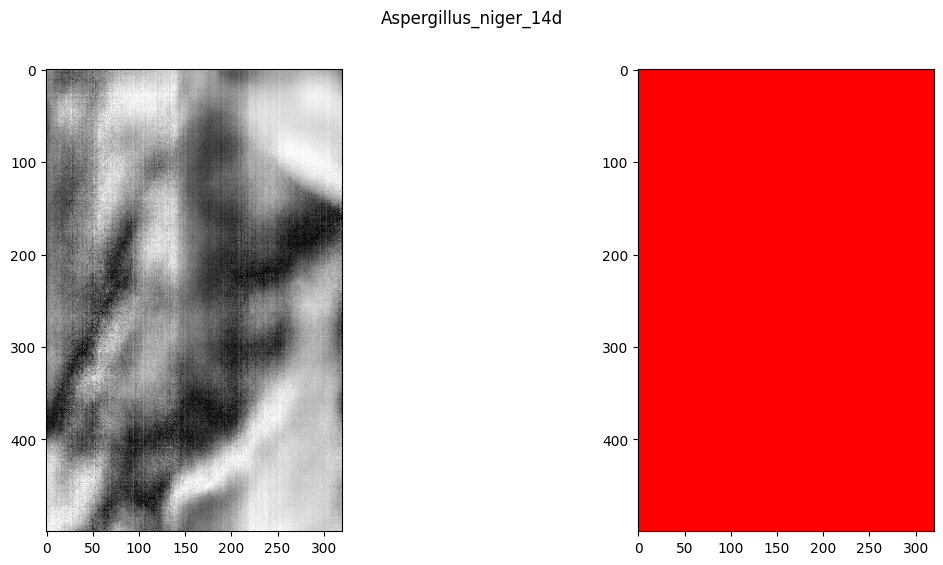

Aspergillus_niger_14d  : (230, 500, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


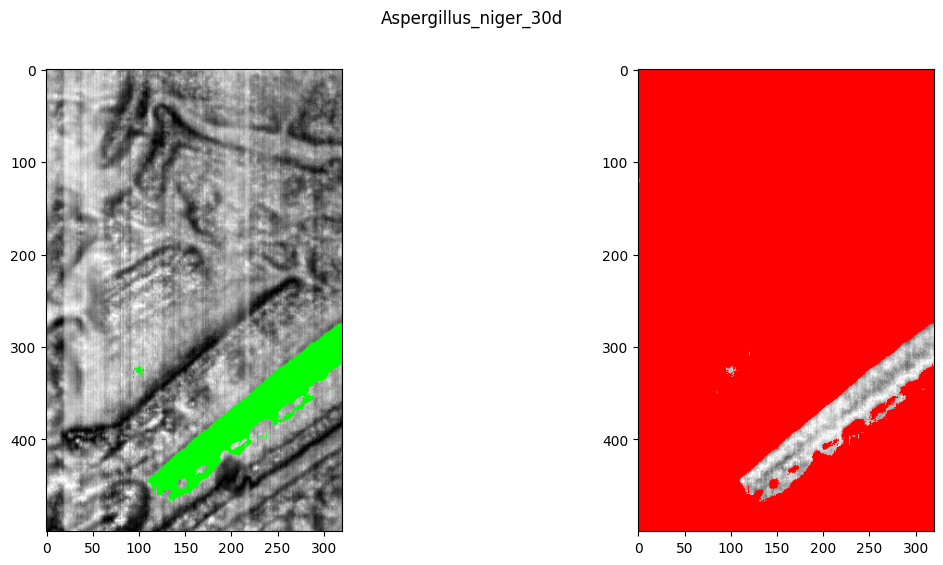

Aspergillus_niger_30d  : (230, 500, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


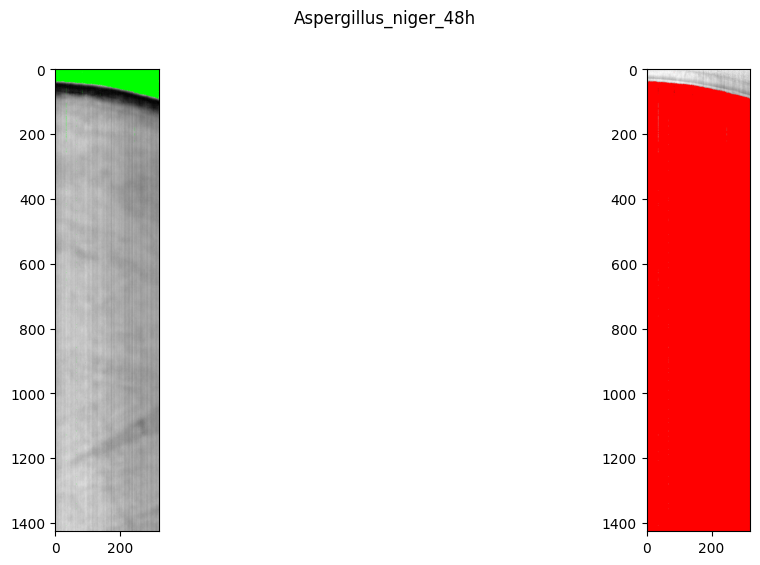

Aspergillus_niger_48h  : (230, 1426, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


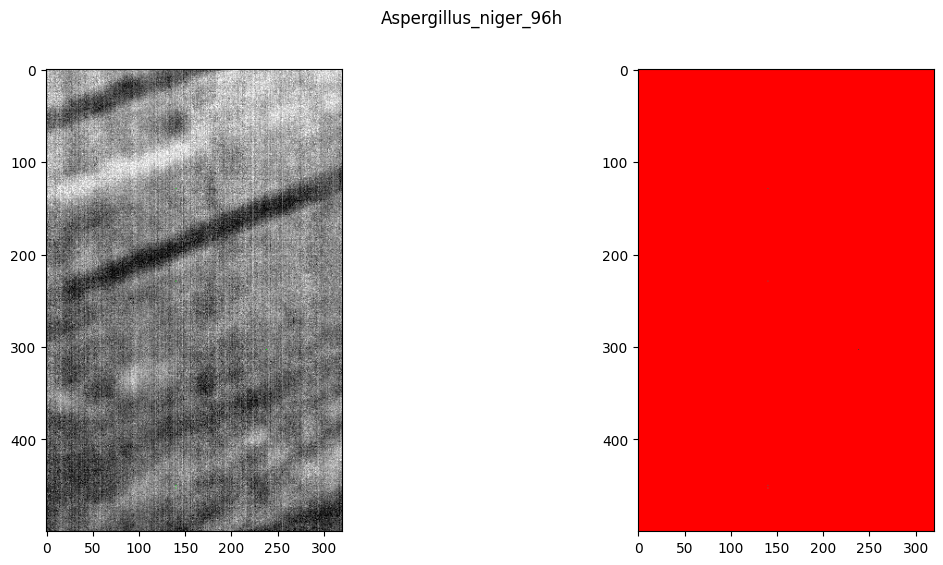

Aspergillus_niger_96h  : (230, 500, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


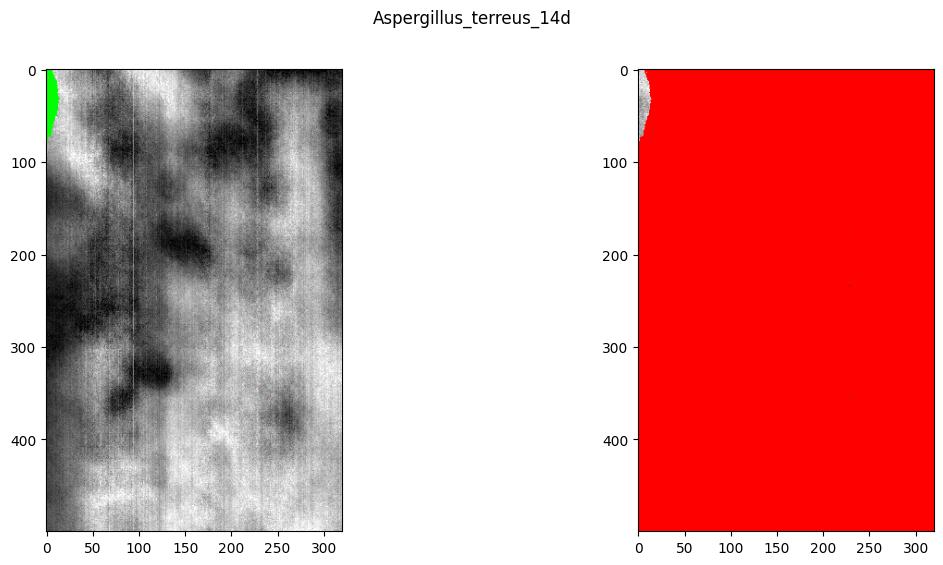

Aspergillus_terreus_14d  : (230, 500, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


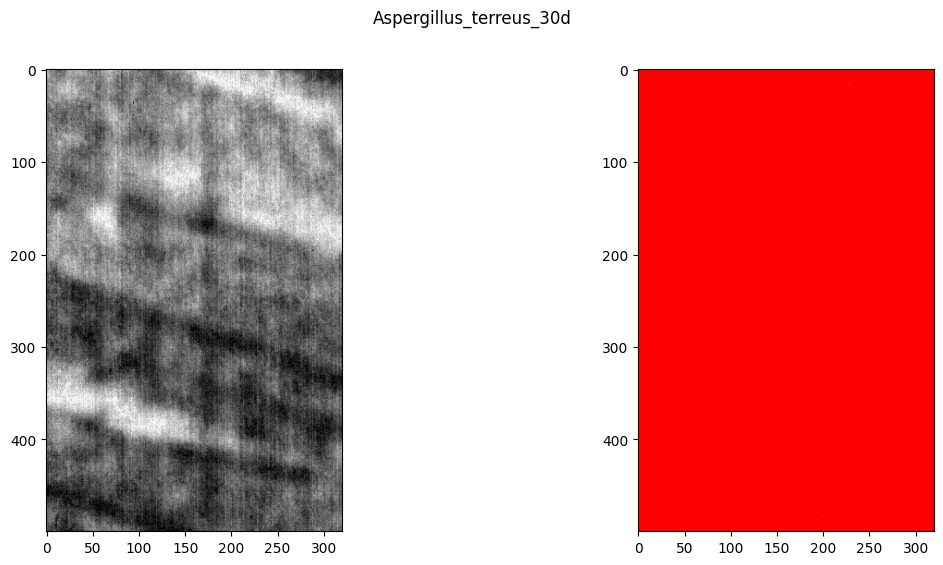

Aspergillus_terreus_30d  : (230, 500, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


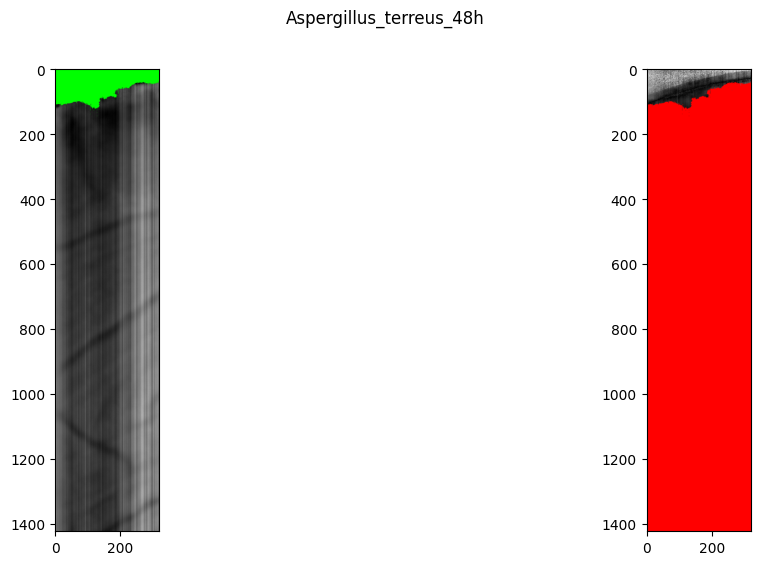

Aspergillus_terreus_48h  : (230, 1423, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


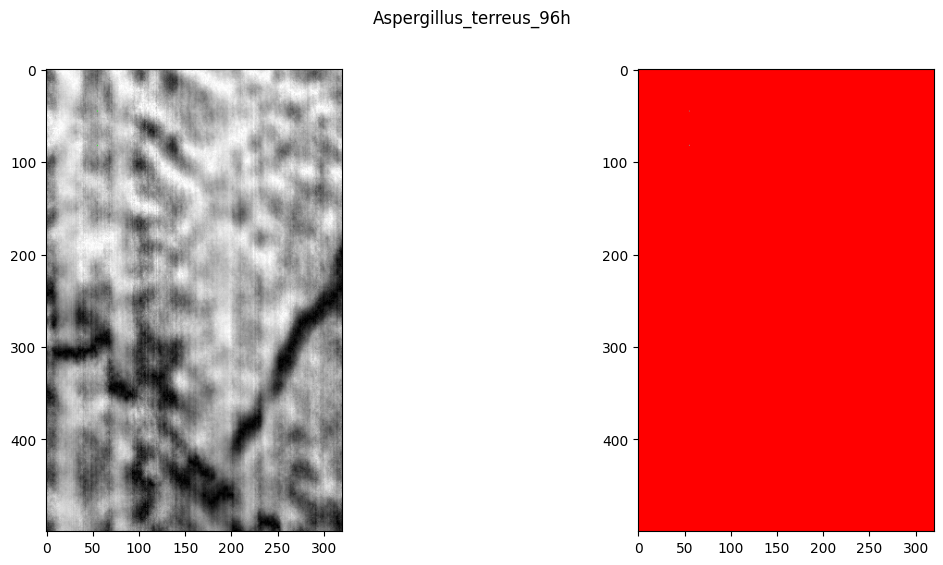

Aspergillus_terreus_96h  : (230, 500, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


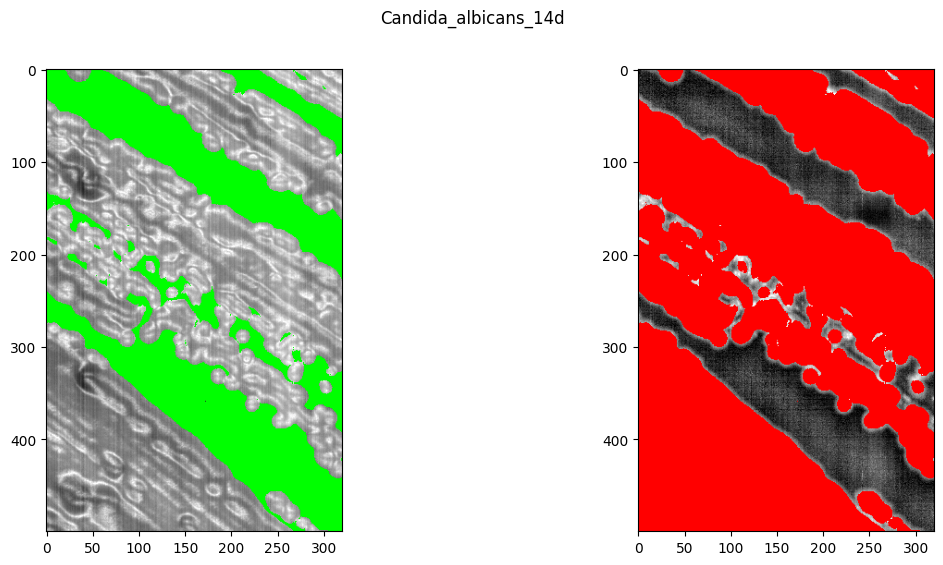

Candida_albicans_14d  : (230, 500, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


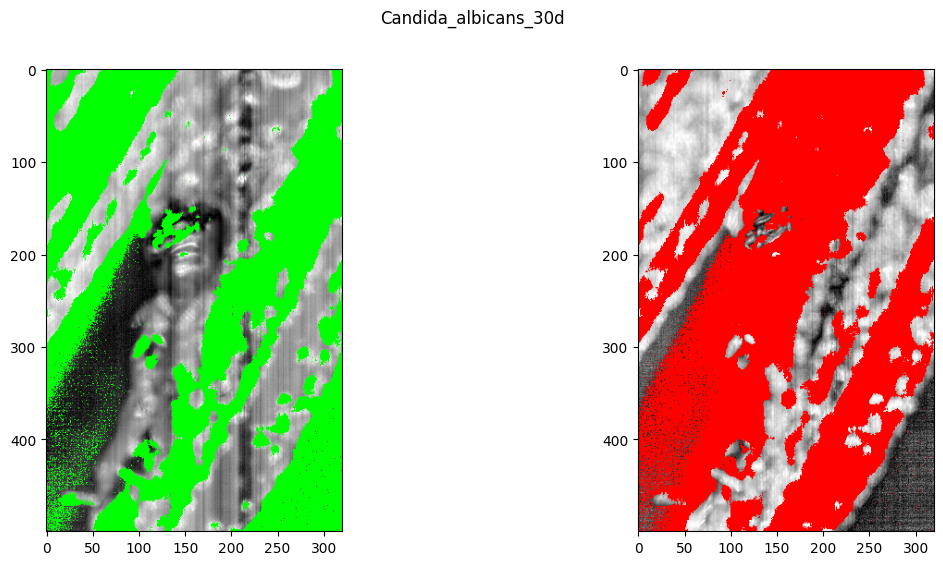

Candida_albicans_30d  : (230, 500, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


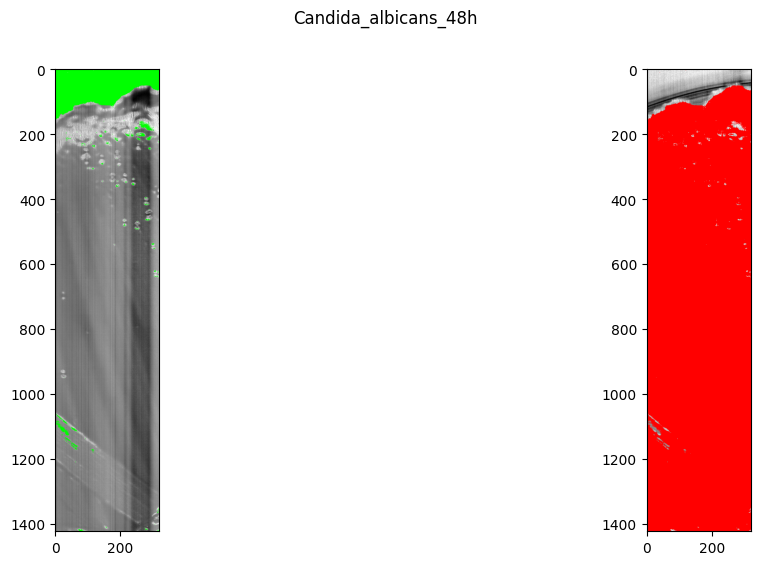

Candida_albicans_48h  : (230, 1423, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


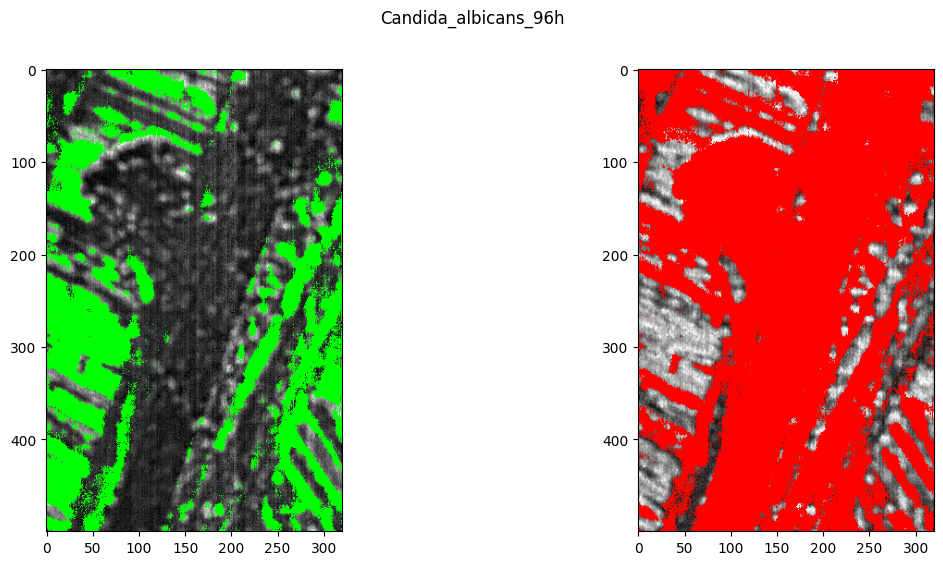

Candida_albicans_96h  : (230, 500, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


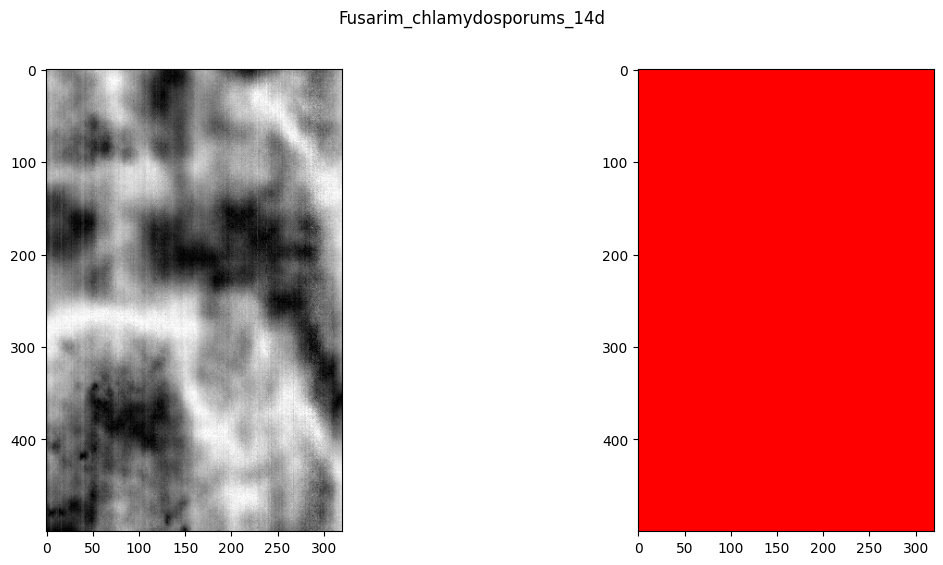

Fusarim_chlamydosporums_14d  : (230, 500, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


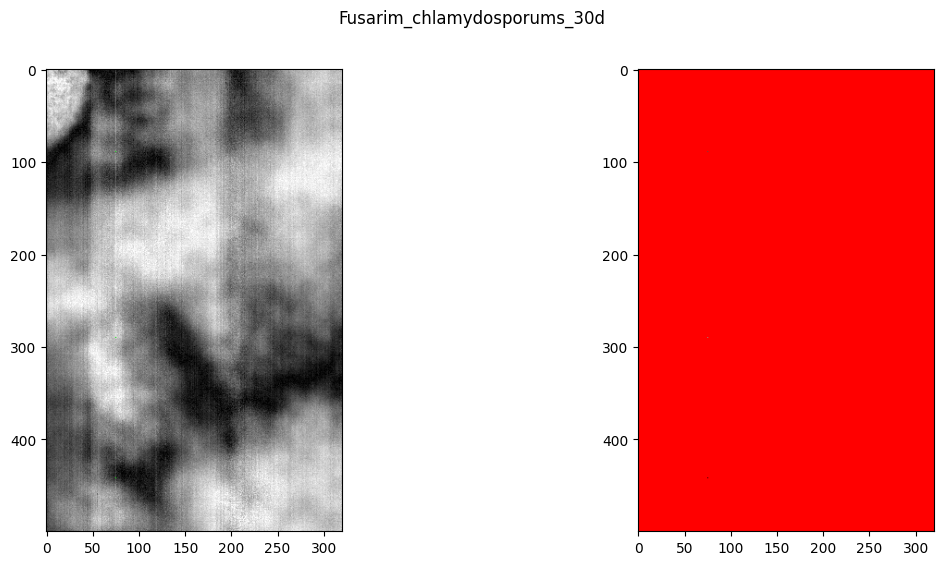

Fusarim_chlamydosporums_30d  : (230, 500, 320)


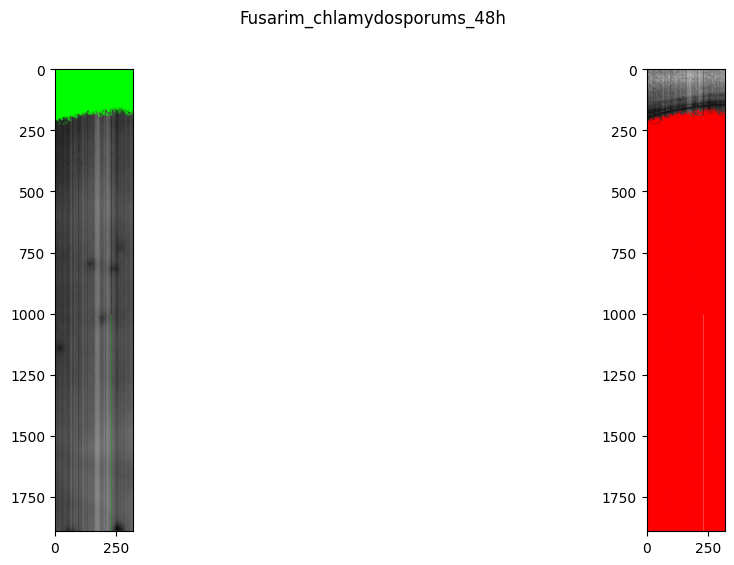

Fusarim_chlamydosporums_48h  : (230, 1892, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


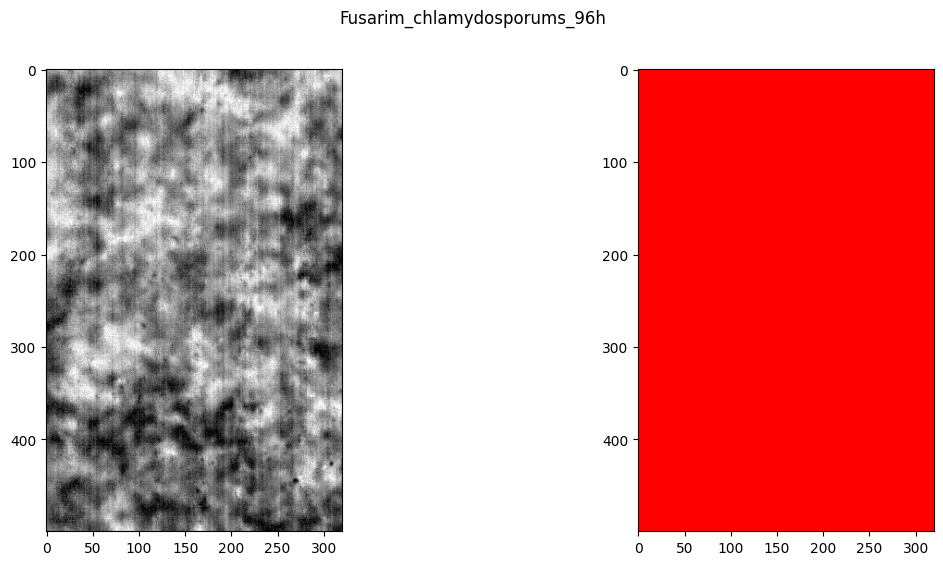

Fusarim_chlamydosporums_96h  : (230, 500, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


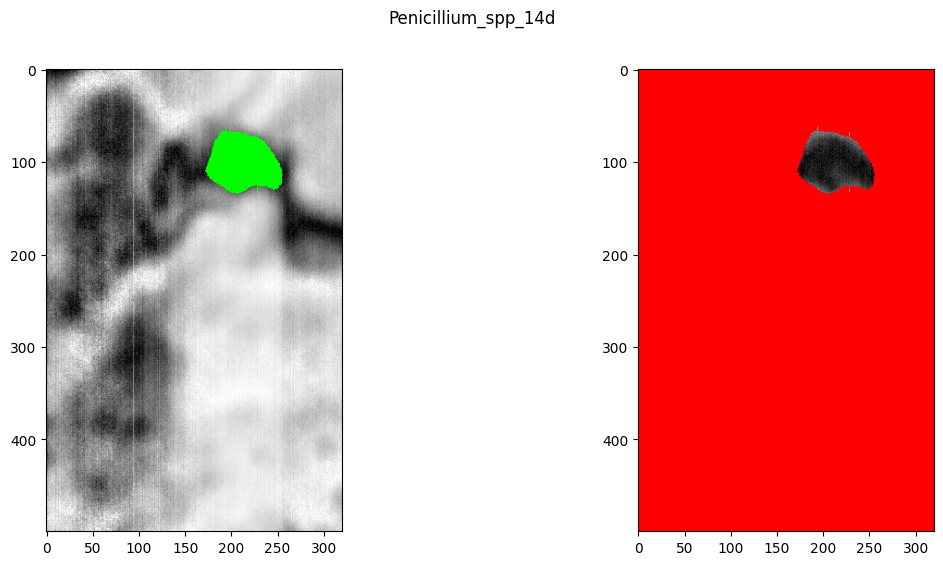

Penicillium_spp_14d  : (230, 500, 320)


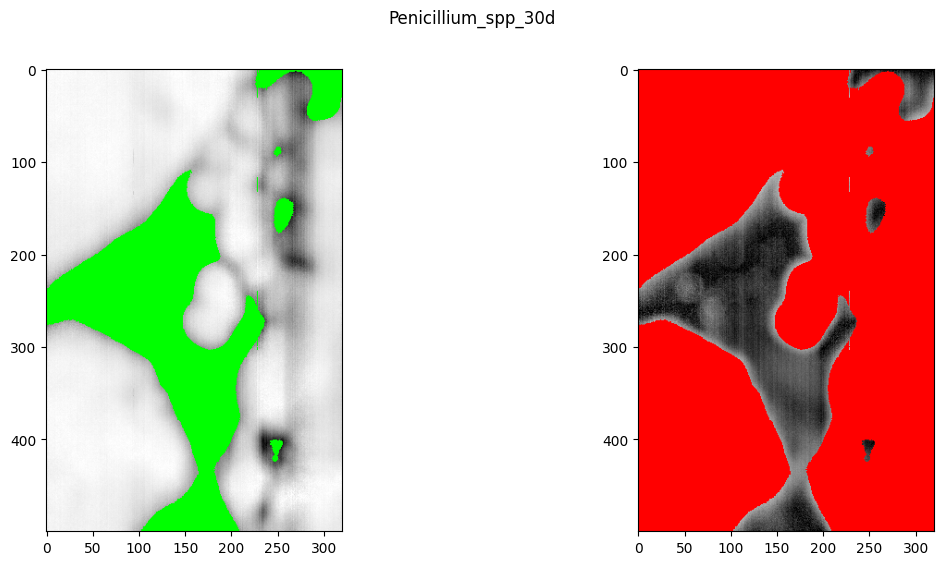

Penicillium_spp_30d  : (230, 500, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


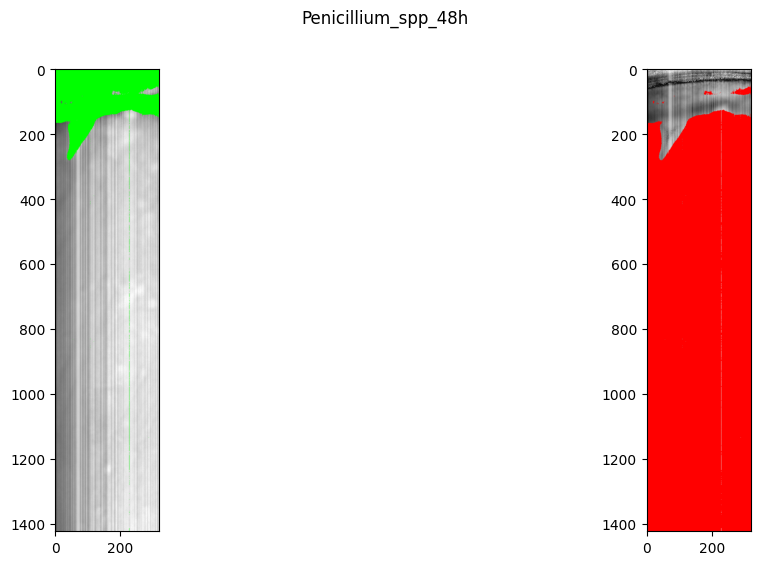

Penicillium_spp_48h  : (230, 1423, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


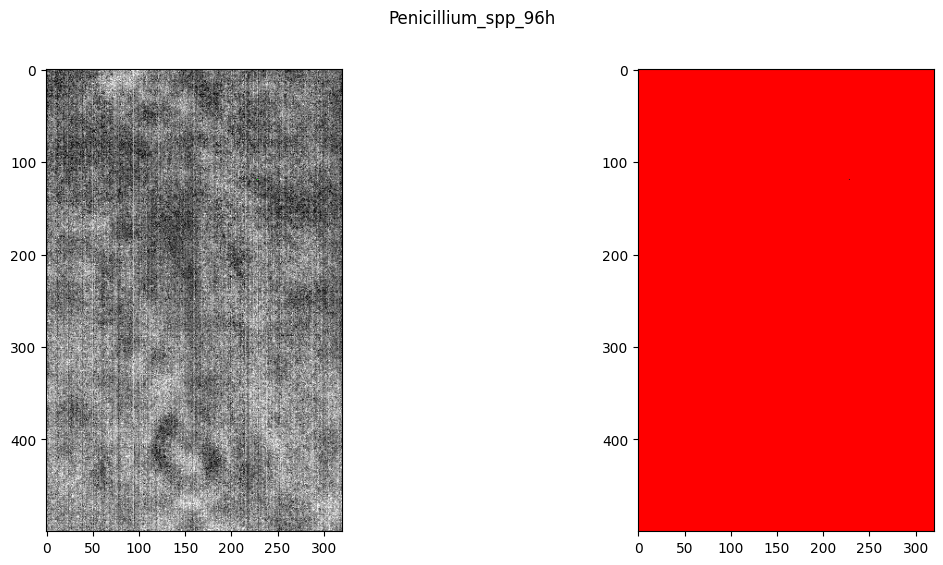

Penicillium_spp_96h  : (230, 500, 320)


In [13]:
time_sample='48h'
test_datas=[f'Aspergillus_niger_{time_sample}', 
            f'Aspergillus_terreus_{time_sample}',
            f'Candida_albicans_{time_sample}',
            f'Fusarim_chlamydosporums_{time_sample}',
            f'Penicillium_spp_{time_sample}']

for i, specie in enumerate(folder_samples):
    for y, sample in enumerate(dict_info[specie]['data_']):
        ## remove data test for training
        task=[sample for test in test_datas if test in sample] 
        ## samples test msut not be subsamples
        
        new_data, new_ind, new_cluster=hsi_crop(dict_info[specie]['data_'][sample],
                                dict_info[specie]['ind_'][sample],
                                dict_info[specie]['cluster_'][sample], 
                                fungus_crop[sample], sample, task, view=True)
        
        dict_info[specie]['data_'][sample]=new_data
        dict_info[specie]['ind_'][sample]=new_ind
        dict_info[specie]['cluster_'][sample]=new_cluster

save_dict(dict_info, folder+f"dict_list_NonFiltertest_{time_sample}.pkl")

In [15]:
'Complete test Sample:', dict_info['Aspergillus_niger']['data_'][test_datas[0]].shape, 'Train Subsample:', dict_info['Aspergillus_niger']['data_']['Aspergillus_niger_96h'].shape

('Complete test Sample:',
 (230, 1426, 320),
 'Train Subsample:',
 (230, 500, 320))

## LOADING AND MANIPULATIONG DATA FOR MODELS TRAINING

### Data Loading

In [7]:
wavelength=np.array([[ 909.17,  915.51,  921.85,  928.19,  934.53,  940.87,  947.21,
         953.54,  959.88,  966.22,  972.55,  978.89,  985.23,  991.56,
         997.9 , 1004.23, 1010.56, 1016.9 , 1023.23, 1029.56, 1035.9 ,
        1042.23, 1048.56, 1054.89, 1061.22, 1067.55, 1073.88, 1080.21,
        1086.54, 1092.87, 1099.19, 1105.52, 1111.85, 1118.18, 1124.5 ,
        1130.83, 1137.16, 1143.48, 1149.81, 1156.13, 1162.45, 1168.78,
        1175.1 , 1181.42, 1187.75, 1194.07, 1200.39, 1206.71, 1213.03,
        1219.35, 1225.67, 1231.99, 1238.31, 1244.63, 1250.95, 1257.27,
        1263.58, 1269.9 , 1276.22, 1282.53, 1288.85, 1295.17, 1301.48,
        1307.79, 1314.11, 1320.42, 1326.74, 1333.05, 1339.36, 1345.67,
        1351.99, 1358.3 , 1364.61, 1370.92, 1377.23, 1383.54, 1389.85,
        1396.16, 1402.47, 1408.77, 1415.08, 1421.39, 1427.7 , 1434.  ,
        1440.31, 1446.62, 1452.92, 1459.23, 1465.53, 1471.83, 1478.14,
        1484.44, 1490.74, 1497.05, 1503.35, 1509.65, 1515.95, 1522.25,
        1528.55, 1534.85, 1541.15, 1547.45, 1553.75, 1560.05, 1566.35,
        1572.64, 1578.94, 1585.24, 1591.53, 1597.83, 1604.13, 1610.42,
        1616.72, 1623.01, 1629.3 , 1635.6 , 1641.89, 1648.18, 1654.48,
        1660.77, 1667.06, 1673.35, 1679.64, 1685.93, 1692.22, 1698.51,
        1704.8 , 1711.09, 1717.38, 1723.66, 1729.95, 1736.24, 1742.53,
        1748.81, 1755.1 , 1761.38, 1767.67, 1773.95, 1780.24, 1786.52,
        1792.8 , 1799.09, 1805.37, 1811.65, 1817.93, 1824.21, 1830.5 ,
        1836.78, 1843.06, 1849.34, 1855.61, 1861.89, 1868.17, 1874.45,
        1880.73, 1887.  , 1893.28, 1899.56, 1905.83, 1912.11, 1918.38,
        1924.66, 1930.93, 1937.21, 1943.48, 1949.75, 1956.03, 1962.3 ,
        1968.57, 1974.84, 1981.11, 1987.39, 1993.66, 1999.93, 2006.19,
        2012.46, 2018.73, 2025.  , 2031.27, 2037.54, 2043.8 , 2050.07,
        2056.34, 2062.6 , 2068.87, 2075.13, 2081.4 , 2087.66, 2093.93,
        2100.19, 2106.45, 2112.71, 2118.98, 2125.24, 2131.5 , 2137.76,
        2144.02, 2150.28, 2156.54, 2162.8 , 2169.06, 2175.32, 2181.58,
        2187.83, 2194.09, 2200.35, 2206.6 , 2212.86, 2219.12, 2225.37,
        2231.63, 2237.88, 2244.13, 2250.39, 2256.64, 2262.89, 2269.15,
        2275.4 , 2281.65, 2287.9 , 2294.15, 2300.4 , 2306.65, 2312.9 ,
        2319.15, 2325.4 , 2331.65, 2337.9 , 2344.14, 2350.39, 2356.64,
        2362.88, 2369.13, 2375.37, 2381.62, 2387.86, 2394.11, 2400.35,
        2406.6 , 2412.84, 2419.08, 2425.32, 2431.57, 2437.81, 2444.05,
        2450.29, 2456.53, 2462.77, 2469.01, 2475.25, 2481.48, 2487.72,
        2493.96, 2500.2 , 2506.43]])

In [8]:
sp.settings.envi_support_nonlowercase_params = True


""" 
    Class HsiExemplarySizing responsável por recortar as capturas hyperspectrais, e dimensionar os dados referntes a fundo e amostra conforme
    o recorte.
 
 """
 
class HsiExemplarySizing:
    def __init__(self, dict_info, 
                 test_datas, Crop_range,
                 folder_samples, view: bool,
                 to_numpy_format=True):

        fungus_crop={
                    'Aspergillus_niger_14d': Crop_range,
                    'Aspergillus_niger_30d': Crop_range,
                    'Aspergillus_niger_48h': Crop_range,
                    'Aspergillus_niger_96h': Crop_range,
                    'Aspergillus_terreus_14d': Crop_range,
                    'Aspergillus_terreus_30d': Crop_range,
                    'Aspergillus_terreus_48h': Crop_range,
                    'Aspergillus_terreus_96h': Crop_range,
                    'Candida_albicans_14d': Crop_range,
                    'Candida_albicans_30d': Crop_range,
                    'Candida_albicans_48h': Crop_range,
                    'Candida_albicans_96h': Crop_range,
                    'Fusarim_chlamydosporums_14d': Crop_range,
                    'Fusarim_chlamydosporums_30d': Crop_range,
                    'Fusarim_chlamydosporums_48h': Crop_range,
                    'Fusarim_chlamydosporums_96h': Crop_range,
                    'Penicillium_spp_14d': Crop_range,
                    'Penicillium_spp_30d': Crop_range,
                    'Penicillium_spp_48h': Crop_range,
                    'Penicillium_spp_96h': Crop_range,
                    }
        
        self.dict_crop=fungus_crop
        
        self._hsi_exemplary(dict_info, 
                            test_datas, 
                            folder_samples, 
                            view)
        
    def _hsi_exemplary(self, dict_info, 
                      test_datas, folder_samples, view):
        
        for i, specie in enumerate(folder_samples):
            for y, sample in enumerate(dict_info[specie]['data_']):
                ## remove data test for training
                task=[sample for test in test_datas if test in sample] 
                ## samples test msut not be subsamples
                
                new_data, new_ind, new_cluster=self.hsi_crop(dict_info[specie]['data_'][sample],
                                        dict_info[specie]['ind_'][sample],
                                        dict_info[specie]['cluster_'][sample], 
                                        self.dict_crop[sample], sample, task, view)
                
                dict_info[specie]['data_'][sample]=new_data
                dict_info[specie]['ind_'][sample]=new_ind
                dict_info[specie]['cluster_'][sample]=new_cluster
        
        self.result=dict_info
    
    def hsi_crop(self, CUBE, ind, cluster, cut, sample, task, view: bool, x=[0,320], w = [5, 235]):
        # Set global debug behavior to None (default), "print" (to file), 
        # or "plot" (Jupyter Notebooks or X11)
        
        ref_img = CUBE[[0], :, :]
        ref_img = np.transpose(np.transpose(ref_img)[0])
        # cropped = img[:, y:y + h, x:x + w]
        
        ## Test samples selection
        if len(task) > 0:
            return self.hsi_crop_test(CUBE, cluster, [1, CUBE.shape[1]], sample, view, x, w), ind, cluster
        
        #clipping the hypercube according to the height-axis coordinates
        cut_cube = CUBE[w[0]:w[1], cut[0]:cut[1], x[0]:x[1] + (w[1]-w[0])]
        
        #completing the ind of samples pixels
        ind, rem = sum_idx_array(realIdx(cluster, 1))
        real_inds = rev_idx_array(ind, rem, tfill=ind)
        
        ## Setting initial and final pixel according to the cut
        inicio=cut[0]*x[1]
        step=cluster.shape[0]-(cut[1]*x[1])
        fim=cluster.shape[0]-step  
        
        #Compenetns pixles selection of the accoding cut
        real_inds=real_inds[inicio:fim]
        real_cluster=cluster[inicio:fim]
        
        if view==True:
            real_inds_plot = rev_idx_array(ind, rem)
            real_inds_plot=real_inds_plot[inicio:fim]
            
            plotimg=getClusters(cut_cube[200,:,:], real_inds_plot, 0, (0,1,0))
            plotimg2=getClusters(cut_cube[200,:,:], real_inds_plot, 1, (1,0,0))
            
            fig = plt.figure(figsize=(14, 6))
            fig.add_subplot(1, 2, 1)
            plt.imshow(plotimg)
            fig.add_subplot(1, 2, 2)
            plt.imshow(plotimg2)
            plt.suptitle(sample)
            plt.show()
        
        ## ind remaked for subsample
        new_array=np.array([i for i in real_inds if i != 0])
        print(sample, ' :', cut_cube.shape)
        
        return cut_cube, new_array, real_cluster

    def hsi_crop_test(self, CUBE, cluster, cut, sample, view, x, w,):
        #clipping the hypercube according to the height-axis coordinates
        cut_cube = CUBE[w[0]:w[1], 0:(CUBE.shape[1]), x[0]:x[1] + (w[1]-w[0])]
        
        if view==True:
                
            ind, rem = sum_idx_array(realIdx(cluster, 1))
            real_inds_plot = rev_idx_array(ind, rem)
            
            plotimg=getClusters(cut_cube[200,:,:], real_inds_plot, 0, (0,1,0))
            plotimg2=getClusters(cut_cube[200,:,:], real_inds_plot, 1, (1,0,0))
            
            fig = plt.figure(figsize=(14, 6))
            fig.add_subplot(1, 2, 1)
            plt.imshow(plotimg)
            fig.add_subplot(1, 2, 2)
            plt.imshow(plotimg2)
            plt.suptitle(sample)
            plt.show()
            print(sample, ' :', cut_cube.shape)
            
        return cut_cube
    
    @property
    def result(self):
        return self.__result

    @result.setter
    def result(self, var):
        self.__result = var

In [9]:
def remove_samples(dict_info, folder_samples, remove):
    
    for sample_rm in remove:
        aux=[sample for i in folder_samples if sample_rm in i]
        if len(aux)>0: 
            folder_samples.remove(sample_rm)
            del dict_info[sample_rm]
        
    return dict_info, folder_samples

def load_dataset(paths, test_datas, Crop_range, view: bool, golay: bool, snv: bool, remove: list):
    ## Get nomeclature of the samples species for path organization
    folder_samples, name_samples=[], []
    dict_info_samples={}
    for load_folders in paths.keys():
        folder_temp=[]

        ## Loading dictonary of samples in path
        dict_info=load_dict(paths[load_folders][2])
        
        path=paths[load_folders][0]
        data_folder=paths[load_folders][1]
        aux=glob.glob(path+data_folder+'/*')
        for i in aux:
            file=i.split('\\')[-1]
            if file == "Meio_BDAY":
                continue
            else:
                folder_temp.append(file)   
        
        #Samples remove before data extraction
        if bool(remove):
            dict_info, folder_temp=remove_samples(dict_info, folder_temp, remove)
            
        folder_samples.extend(folder_temp) 
    
        for i in folder_temp:
            for name in dict_info[i]['ind_']:
                name_samples.append(name)
        
        data_dicts=[]
        data_dicts=load_pkl([path], folder_temp, data_folder, golay, snv)
        
        for i, sample_class in enumerate(data_dicts):
            x=list(sample_class.keys())
            fir=x[0].split('_')[0]
            sec=x[0].split('_')[1]
            conc=[fir, sec]
            variable_name=('_').join(conc)
            # print(variable_name)
            # if 'Fungo' in variable_name:
            #     variable_name= 'Manisopliae'
            
            if 'Meio' in variable_name:
                continue
            
            key='data_'
            dict_info[variable_name][key]= data_dicts[i]
        
        ## Return images without preprocess
        if not Crop_range:
            return dict_info, folder_samples, name_samples
        
        ## Subsamples producted
        hsi_examplary=HsiExemplarySizing(dict_info, 
                                            test_datas, Crop_range,
                                            folder_temp, view)
        
        dict_info_samples.update(hsi_examplary.result)

    return dict_info_samples, folder_samples, name_samples

In [48]:
base_path='C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/'

# Data path and necessarie folders
# dict_paths[key][0]: repository folder , dict_paths[key][1]: data, 
# dict_paths[key][2]: dict cluster.pkl, 
# dict_paths[key][3]: main folder


dict_paths={ 'Fungus': [f'{base_path}datas/fungus_classification/','data_process_raw',
                        f'{base_path}LCC_Fungus/dict_list_clusters.pkl',
                        f'{base_path}LCC_Fungus/'
                        ],
            # 'Carrapatos':[f'{base_path}datas/carrapatos/','data_process_raw',
            #               f'{base_path}IPTSP_InfectedTicks/dict_list_clusters.pkl',
            #               f'{base_path}IPTSP_InfectedTicks/'
            #               ]
            }

# remove=''
remove=["Aspergillus_niger"]

## Time samples fungus for test model
time_sample='14d'
test_datas=[]
# test_datas=[f'Aspergillus_niger_{time_sample}', 
#             f'Aspergillus_terreus_{time_sample}',
#             f'Candida_albicans_{time_sample}',
#             f'Fusarim_chlamydosporums_{time_sample}',
#             f'Penicillium_spp_{time_sample}']

## Data process loading
dict_info, folder_samples, name_samples=load_dataset(dict_paths, test_datas,
                                                    Crop_range=[], view=False,
                                                    golay=True, snv=True,
                                                    remove=remove)

C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/datas/fungus_classification/data_process_raw\Aspergillus_terreus\Aspergillus_terreus_14d/Aspergillus_terreus_14d.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/datas/fungus_classification/data_process_raw\Aspergillus_terreus\Aspergillus_terreus_30d/Aspergillus_terreus_30d.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/datas/fungus_classification/data_process_raw\Aspergillus_terreus\Aspergillus_terreus_48h/Aspergillus_terreus_48h.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/datas/fungus_classification/data_process_raw\Aspergillus_terreus\Aspergillus_terreus_96h/Aspergillus_terreus_96h.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/datas/fungus_classification/data_process_raw\Candida_albicans\Candida_albicans_14d/Candida_albicans_14d.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/datas/fungus_classification/data_process_raw\Candida_albicans\Candida_albicans_30d/Candida_albicans_30d.pkl
C:/U

In [49]:
y = 0
for z, classes in enumerate(dict_info.keys()): 
    for i, sample in enumerate(list(dict_info[classes]['data_'].keys())):
        print(name_samples[y], dict_info[classes]['data_'][sample].shape)
        y=y+1

Aspergillus_terreus_14d (256, 1424, 320)
Aspergillus_terreus_30d (256, 1423, 320)
Aspergillus_terreus_48h (256, 1423, 320)
Aspergillus_terreus_96h (256, 1423, 320)
Candida_albicans_14d (256, 1423, 320)
Candida_albicans_30d (256, 1423, 320)
Candida_albicans_48h (256, 1423, 320)
Candida_albicans_96h (256, 1423, 320)
Fusarim_chlamydosporums_14d (256, 1425, 320)
Fusarim_chlamydosporums_30d (256, 1423, 320)
Fusarim_chlamydosporums_48h (256, 1892, 320)
Fusarim_chlamydosporums_96h (256, 1422, 320)
Penicillium_spp_14d (256, 1423, 320)
Penicillium_spp_30d (256, 1422, 320)
Penicillium_spp_48h (256, 1423, 320)
Penicillium_spp_96h (256, 1423, 320)


In [12]:
import random

name1, _ = random.choice(list(dict_info.items()))
name, _ = random.choice(list(dict(dict_info[name1]['data_']).items()))
# setting the global variable of the amount of spectral bands
num_spectrum=dict_info[name1]['data_'][name].shape[0]
print(num_spectrum)

256


### Creating dataset for training and testting

In [118]:
def get_Xy(DATA, info, sample_cluster, spectral_range=(0, num_spectrum+1)):

    X_test = np.array([]).reshape(0, spectral_range[1] - spectral_range[0])
    X_train = np.array([]).reshape(0, spectral_range[1] - spectral_range[0])
    y_test = np.array([]).reshape(-1, 1)
    y_train = np.array([]).reshape(-1, 1)

    for key in DATA.keys():
        data = DATA[key]
        # data = moveAxis(data)
        matrix = hsi2matrix(data)
        matrix = matrix[:, spectral_range[0]:spectral_range[1]]

        ind, _ = sum_idx_array(realIdx(sample_cluster[key], 1))

        idx_train, idx_test = train_test_split(ind, test_size=info[key][1], shuffle=False)

        X_test = np.vstack([X_test, matrix[idx_test]])
        X_train = np.vstack([X_train, matrix[idx_train]])

        # print(key,'----->', data.shape, data[150,140,:])
        # print(X_train, X_test)
        # print(idx_train.shape, idx_test.shape)

        #Setando os targets
        y = np.ones(idx_train.shape) * info[key][0]
        y = y.reshape(-1, 1)
        y_train = np.vstack([y_train, y])

        y = np.ones(idx_test.shape) * info[key][0] 
        y = y.reshape(-1, 1)
        y_test = np.vstack([y_test, y])

        # print(X_train, y_train, '\n', X_train.shape, y_train.shape)

        # VISUALIZATION
        # size_train = len(sample_cluster[key]) * (1 - info[key][1])

        # X_train_separation = sample_cluster[key][:int(size_train)]
        # X_test_separation = sample_cluster[key][len(X_train_separation):]

        # X_test_separation_aux = np.ones(len(X_test_separation)) * 2
        # idx_test, rem = sum_idx_array(realIdx(X_test_separation, 1))
        # X_test_separation = rev_idx_array(idx_test, rem, tfill=X_test_separation_aux)

        # sample_cluster_visualizate = np.concatenate((X_train_separation, X_test_separation))
        # visualization_sample_separation(data[50,:,:], sample_cluster_visualizate, key)

    return X_train, X_test, y_train, y_test


def visualization_sample_separation(image, sample_cluster, key, X_train_size=None, X_test_size=None):
    image = getClusters(image, sample_cluster, 1, (1, 0, 0))
    image = getClusters(image, sample_cluster, 2, (0, 1, 0))

    red_patch = mpatches.Patch(color='red', label='Trian size')
    green_patch = mpatches.Patch(color='green', label='Test size')

    fig, ax = plt.subplots(figsize=(12,8))

    ax.axis()
    ax.imshow(rgbscale(image))
    fig.legend(title='Separation', handles=[red_patch, green_patch], loc='center right')
    plt.title('Sample: ' + key)
    plt.show()


def get_Xy_DataFrame(DATA, sample_cluster, target, task="", exception=list, 
                     spectral_range=(0, num_spectrum+1)):
    df = pd.DataFrame()

    X_ = np.array([]).reshape(0, spectral_range[1] - spectral_range[0])
    y_ = np.array([]).reshape(-1, 1)

    for key in DATA.keys():
        
        temp=[key for name in exception if name in key]
        if len(temp)>0:
            print(temp)
            continue
        
        data = DATA[key]
        
        matrix = hsi2matrix(data)
        matrix = matrix[:, spectral_range[0]:spectral_range[1]]

        ind, _ = sum_idx_array(realIdx(sample_cluster[key], 1))

        X_ = pd.DataFrame(matrix[ind])
        
        y = np.ones(ind.shape)*target
        y = y.reshape(-1, 1)
        y_ = np.vstack([y_, y])
        
        df = df.append(X_)
        
        if not task:
            continue
        else:
            target=target+1
    
    if not temp:
        df = df.assign(target = y_)
        # df.columns = [f'{i}nm' for i in range(900,2514, 7)]+['target']
        df.columns = [f'band-{i}' for i in range(1, num_spectrum+1)]+['target']

    return target, df

def plot_spectrum_analysis(dict_samples, 
                           ind_, 
                           df, 
                           name_file,
                           tittle, 
                           tam0, 
                           exception=list):
    dict_plot={}
    for key in dict_samples:  
        temp=[key for name in exception if name in key]
        if len(temp)>0:
            # print(temp)
            continue
        
        tam=ind_[key].shape[0]
        tam=(tam+tam0)
        dict_plot[key]=df.iloc[tam0:tam,:num_spectrum]
        tam0=tam
    
    x_axis = wavelength
    
    # #all Spectral
    fig, axes = plt.subplots(figsize=(12, 6), dpi=1000)
    for i, sample in enumerate(dict_plot.keys()):
        plt.plot(dict_plot[sample].mean(), label=sample)
    plt.title(f'{tittle} captures',fontsize=19)
    plt.legend()
    ind = np.linspace(0, x_axis.shape[1] - 1, num=5, dtype=int)

    axes.set_ylabel("Pseudo Absorbance")
    axes.set_xlabel("Wavelength (nm)")
    axes.set_xticks(ind)
    axes.set_xticklabels(x_axis[0, ind])
    # plt.savefig(folder+f'{name_file}_{tittle}.pdf')
    # # plt.close(fig)
    # plt.show()
  
    return dict_plot, tam0

In [119]:
# teste2 = np.arange(48).reshape(-1, 4, 4) 
# kmeans_result = np.array([0, 0, 1, 1, 1, 1, 0,0, 1, 1, 1, 1])

# print(teste2)

# X_train0, X_test0, y_train1, y_test1 = get_Xy(teste2, 0.5, kmeans_result, 1)

In [120]:
test_datas

[]

In [121]:
# Targets: 1 -> Fungus
#          2 -> R. Microplus controle
# time_sample='14d'
# test_datas=[
#             f'Aspergillus_niger_{time_sample}', 
#             f'Aspergillus_terreus_{time_sample}',
#             f'Candida_albicans_{time_sample}',
#             f'Fusarim_chlamydosporums_{time_sample}',
#             f'Penicillium_spp_{time_sample}']
test_datas=[]
train_exception=test_datas
df_train, dict_plot_train=pd.DataFrame(), {}
target=1
tam=0

for i, sample_class in enumerate(dict_info.keys()):
    
    target, df_temp=get_Xy_DataFrame(dict_info[sample_class]['data_'],
                                               dict_info[sample_class]['cluster_'], 
                                               target=target, exception=list(train_exception))
    df_train= df_train.append(df_temp, ignore_index=True)
    target=target+1

    # var_values, tam=plot_spectrum_analysis(dict_info[sample_class]['data_'], 
    #                                        dict_info[sample_class]['ind_'], 
    #                                        df_train, 'train', sample_class, 
    #                                        tam, exception=list(train_exception))
    
    # dict_plot_train[sample_class]=var_values
    del df_temp
# Scrambling training data
df_train = shuffle(df_train)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_20344\619674491.py:95: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_20344\619674491.py:95: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_20344\2692715555.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_20344\619674491.py:95: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_20344\619674491.py:95: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

In [76]:
df_train

band-1    band-2    band-3    band-4    band-5    band-6    band-7  \
35088    0.187898  0.193353  0.185247  0.175774  0.169760  0.161273  0.156014   
165684   0.195804  0.184565  0.173883  0.161822  0.163548  0.152833  0.148056   
165326   0.187364  0.182081  0.179084  0.167010  0.159135  0.152112  0.144858   
1920347  0.165072  0.154253  0.143474  0.140443  0.132782  0.122017  0.114337   
986682   0.496192  0.415892  0.391468  0.421650  0.452641  0.396179  0.395357   
...           ...       ...       ...       ...       ...       ...       ...   
57055    0.177123  0.183997  0.180991  0.168433  0.163511  0.153808  0.147317   
1554493  0.196571  0.173345  0.177988  0.167002  0.162470  0.149677  0.149595   
34501    0.203187  0.195112  0.182868  0.191100  0.176969  0.171514  0.163237   
286668   0.232715  0.223634  0.214345  0.213180  0.210887  0.192832  0.179991   
641424   0.288585  0.277880  0.272878  0.255823  0.247407  0.237198  0.230667   

           band-8    band-9   band-10  ...  band-222  band-223  band-224  \
35088    0.150184  0.144107  0.135924  ... -0.107726 -0.109591 -0.107032   
165684   0.135682  0.135488  0.122101  ... -0.102214 -0.101812 -0.102271   
165326   0.137756  0.132631  0.125112  ... -0.098638 -0.103443 -0.100954   
1920347  0.113545  0.104385  0.099918  ... -0.083689 -0.085319 -0.078436   
986682   0.433964  0.368135  0.383506  ... -0.596616 -0.594067 -0.599929   
...           ...       ...       ...  ...       ...       ...       ...   
57055    0.143228  0.135669  0.124287  ... -0.110724 -0.112008 -0.103955   
1554493  0.140069  0.130753  0.130604  ... -0.114343 -0.114264 -0.116280   
34501    0.159442  0.150011  0.146592  ... -0.118278 -0.114838 -0.113368   
286668   0.171560  0.166317  0.161786  ... -0.133899 -0.132596 -0.136696   
641424   0.214010  0.203634  0.188678  ... -0.168508 -0.168257 -0.164170   

         band-225  band-226  band-227  band-228  band-229  band-230  target  
35088   -0.098677 -0.106910 -0.103151 -0.105222 -0.103705 -0.099028     1.0  
165684  -0.103346 -0.096899 -0.106844 -0.101516 -0.100879 -0.097477     1.0  
165326  -0.095121 -0.098492 -0.098954 -0.100829 -0.101425 -0.095383     1.0  
1920347 -0.081614 -0.080346 -0.079701 -0.083014 -0.078117 -0.082402     3.0  
986682  -0.602172 -0.601922 -0.600096 -0.589617 -0.585264 -0.568146     2.0  
...           ...       ...       ...       ...       ...       ...     ...  
57055   -0.107797 -0.111801 -0.109844 -0.111985 -0.109646 -0.102856     1.0  
1554493 -0.112760 -0.116663 -0.109016 -0.119434 -0.108819 -0.109939     3.0  
34501   -0.110001 -0.117986 -0.117476 -0.107893 -0.111033 -0.109682     1.0  
286668  -0.129424 -0.124842 -0.131093 -0.129157 -0.127085 -0.127519     1.0  
641424  -0.162455 -0.164614 -0.158713 -0.155456 -0.166556 -0.153254     1.0  

[2830844 rows x 231 columns]

In [ ]:
test_samples=test_datas
df_test, dict_plot_test=pd.DataFrame(), {}

test_exception=name_samples

for x in test_samples:
    temp=[x for i in test_exception if x in i]
    if len(temp)>0:
        test_exception.remove(x)
    
target=1
tam=0

for i, sample_class in enumerate(dict_info.keys()):
    
    target, df_temp=get_Xy_DataFrame(dict_info[sample_class]['data_'],
                                               dict_info[sample_class]['cluster_'], 
                                               target=target, exception=list(name_samples))
    df_test= df_test.append(df_temp, ignore_index=True)
    target=target+1

    var_values, tam=plot_spectrum_analysis(dict_info[sample_class]['data_'], dict_info[sample_class]['ind_'], 
                              df_test, 'test', sample_class, tam, exception=list(test_exception))
    
    dict_plot_test[sample_class]=var_values

# Scrambling training data
df_test = shuffle(df_test)

In [30]:
colors = {
            '1': ['#FFA500', 'Aspergillus terreus'],#laranja
            '2': ['#0000FF', 'Candida albicans'],#azul
            '3': ['#FF00FF', 'Fusarim chlamydosporums'],#Magenta
            '4': ['#00FFFF', 'Penicillium spp'],#cyan
        }

In [ ]:
fig, axes = plt.subplots(figsize=(12, 6), dpi=1000)
x_axis = wavelength
for (i, samples), (color) in zip(enumerate(dict_plot_train.keys()), (colors.keys())):
    df=pd.DataFrame()
    for y, samples_pclass in enumerate(dict_plot_train[samples]):
        df=pd.concat([df, dict_plot_train[samples][samples_pclass]])
    plt.plot(df.mean(), label=samples, color=str(colors[color][0]))
# plt.title(f'Mean Spectrus Data Test',fontsize=19)
plt.legend()
ind = np.linspace(0, x_axis.shape[1] - 1, num=5, dtype=int)
axes.set_ylabel("Pseudo Absorbance")
axes.set_xlabel("Wavelength (nm)")
axes.set_xticks(ind)
axes.set_xticklabels(x_axis[0, ind])

os.makedirs(os.path.join(dict_paths['Fungus'][3], 'plots'), exist_ok=True)
plt.savefig(dict_paths['Fungus'][3]+f'plots/spectrum_mean_train.pdf')

plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(12, 6), dpi=1000)
x_axis = wavelength
for (i, samples), (color) in zip(enumerate(dict_plot_test.keys()), (colors.keys())):
    df=pd.DataFrame()
    for y, samples_pclass in enumerate(dict_plot_test[samples]):
        df=pd.concat([df, dict_plot_test[samples][samples_pclass]])
    plt.plot(df.mean(), label=samples, color=str(colors[color][0]))
# plt.title(f'Mean Spectrus Data Test',fontsize=19)
plt.legend()
ind = np.linspace(0, x_axis.shape[1] - 1, num=5, dtype=int)
axes.set_ylabel("Pseudo Absorbance")
axes.set_xlabel("Wavelength (nm)")
axes.set_xticks(ind)
axes.set_xticklabels(x_axis[0, ind])

os.makedirs(os.path.join(dict_paths['Fungus'][3], 'plots'), exist_ok=True)
plt.savefig(dict_paths['Fungus'][3]+f'plots/spectrum_mean_test.pdf')

plt.show()

In [30]:
len(df_train.loc[df_train['target']==1.0]), len(df_train.loc[df_train['target']==2.0]), len(df_train.loc[df_train['target']==3.0]), len(df_train.loc[df_train['target']==4.0]), len(df_train.loc[df_train['target']==5.0]), len(df_train.loc[df_train['target']==6.0]), len(df_train.loc[df_train['target']==7.0])

(0, 479991, 367224, 479763, 443230, 0, 0)

In [31]:
len(df_test.loc[df_test['target']==1.0]), len(df_test.loc[df_test['target']==2.0]), len(df_test.loc[df_test['target']==3.0]), len(df_test.loc[df_test['target']==4.0]), len(df_test.loc[df_test['target']==5.0]), len(df_test.loc[df_test['target']==6.0]), len(df_test.loc[df_test['target']==7.0])

NameError: name 'df_test' is not defined

In [17]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                      df_train:  3.1 GiB
                           _i6: 14.1 KiB
                           _i1: 11.5 KiB
                           _i9: 11.5 KiB
                           _i5:  9.3 KiB
                           _i4:  5.4 KiB
                          _iii:  4.7 KiB
                          _i14:  4.7 KiB
                           _i7:  4.1 KiB
                          _i10:  1.8 KiB


## Plots

#### Confusion Matrix

In [122]:
rating = []
for row in df_train['target']:
    if row == 1.0:     rating.append('Aspergillus_terreus')
    elif row == 2.0:   rating.append('Candida_albicans')
    elif row == 3.0:   rating.append('Fusarim_chlamydosporums')
    elif row == 4.0:   rating.append('Penicillium_spp_')
    # elif row < 5.0:  rating.append('C')
df_train['species']=rating

In [123]:
colors = {
            '1': ['#FFA500', 'Aspergillus terreus'],#laranja
            '2': ['#0000FF', 'Candida albicans'],#azul
            '3': ['#FF00FF', 'Fusarim chlamydosporums'],#Magenta
            '4': ['#00FFFF', 'Penicillium spp'],#cyan
        }

In [100]:
fig.update_traces

<bound method BaseFigure.update_traces of Figure({
    'data': [{'diagonal': {'visible': False},
              'dimensions': [{'axis': {'matches': True},
                              'label': 'PC 1 (81.8%)',
                              'values': array([-0.45375036, -0.52006419, -0.52105062, ..., -0.26040931, -0.25221892,
                                                0.36402012])},
                             {'axis': {'matches': True},
                              'label': 'PC 2 (4.0%)',
                              'values': array([ 0.23065729,  0.28660513,  0.27354963, ...,  0.16783084,  0.11073934,
                                               -0.34334065])},
                             {'axis': {'matches': True},
                              'label': 'PC 3 (2.6%)',
                              'values': array([-0.18695495, -0.21137568, -0.20485763, ..., -0.19905043, -0.1893839 ,
                                               -0.10108646])}],
              'hovertemplate

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA

# df = px.data.iris()
# features = ["sepal_width", "sepal_length", "petal_width", "petal_length"]
# df_plot=df_train.iloc[:300000,:]
# del df_train

colors_list=[colors[key][0] for key in colors.keys() if bool(colors[key][0])==True]

df_plot=df_train.iloc[:300000,:]
# del df_train

df_plot=df_plot.sort_values(by='target')

pca = PCA(n_components=3)
components = pca.fit_transform(df_plot.iloc[:,:230])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components, 
    labels=labels,
    dimensions=range(3),
    color=df_plot.iloc[:,231],
    color_discrete_sequence=colors_list,
    opacity=1,
    size_max=10,
    template='presentation',
)

fig.update_traces(diagonal_visible=False, marker=dict(size=5))
fig.update_layout({"title": {"text": "",
                             "font": {"size": 10}}})
fig.update_layout(font_size=30)
fig.update_layout(
    dragmode='select',
    width=2500,
    height=2000,
    hovermode='closest',
    # title=go.layout.Title(text="",font=go.layout.title.Font(size=30))
)


# plt.savefig(dict_paths['Fungus'][3]+f'/images/plotes/pca_analisis.png')
fig.show()

### Remove Backgrounf

In [134]:
wavelength=np.array([[ 909.17,  915.51,  921.85,  928.19,  934.53,  940.87,  947.21,
         953.54,  959.88,  966.22,  972.55,  978.89,  985.23,  991.56,
         997.9 , 1004.23, 1010.56, 1016.9 , 1023.23, 1029.56, 1035.9 ,
        1042.23, 1048.56, 1054.89, 1061.22, 1067.55, 1073.88, 1080.21,
        1086.54, 1092.87, 1099.19, 1105.52, 1111.85, 1118.18, 1124.5 ,
        1130.83, 1137.16, 1143.48, 1149.81, 1156.13, 1162.45, 1168.78,
        1175.1 , 1181.42, 1187.75, 1194.07, 1200.39, 1206.71, 1213.03,
        1219.35, 1225.67, 1231.99, 1238.31, 1244.63, 1250.95, 1257.27,
        1263.58, 1269.9 , 1276.22, 1282.53, 1288.85, 1295.17, 1301.48,
        1307.79, 1314.11, 1320.42, 1326.74, 1333.05, 1339.36, 1345.67,
        1351.99, 1358.3 , 1364.61, 1370.92, 1377.23, 1383.54, 1389.85,
        1396.16, 1402.47, 1408.77, 1415.08, 1421.39, 1427.7 , 1434.  ,
        1440.31, 1446.62, 1452.92, 1459.23, 1465.53, 1471.83, 1478.14,
        1484.44, 1490.74, 1497.05, 1503.35, 1509.65, 1515.95, 1522.25,
        1528.55, 1534.85, 1541.15, 1547.45, 1553.75, 1560.05, 1566.35,
        1572.64, 1578.94, 1585.24, 1591.53, 1597.83, 1604.13, 1610.42,
        1616.72, 1623.01, 1629.3 , 1635.6 , 1641.89, 1648.18, 1654.48,
        1660.77, 1667.06, 1673.35, 1679.64, 1685.93, 1692.22, 1698.51,
        1704.8 , 1711.09, 1717.38, 1723.66, 1729.95, 1736.24, 1742.53,
        1748.81, 1755.1 , 1761.38, 1767.67, 1773.95, 1780.24, 1786.52,
        1792.8 , 1799.09, 1805.37, 1811.65, 1817.93, 1824.21, 1830.5 ,
        1836.78, 1843.06, 1849.34, 1855.61, 1861.89, 1868.17, 1874.45,
        1880.73, 1887.  , 1893.28, 1899.56, 1905.83, 1912.11, 1918.38,
        1924.66, 1930.93, 1937.21, 1943.48, 1949.75, 1956.03, 1962.3 ,
        1968.57, 1974.84, 1981.11, 1987.39, 1993.66, 1999.93, 2006.19,
        2012.46, 2018.73, 2025.  , 2031.27, 2037.54, 2043.8 , 2050.07,
        2056.34, 2062.6 , 2068.87, 2075.13, 2081.4 , 2087.66, 2093.93,
        2100.19, 2106.45, 2112.71, 2118.98, 2125.24, 2131.5 , 2137.76,
        2144.02, 2150.28, 2156.54, 2162.8 , 2169.06, 2175.32, 2181.58,
        2187.83, 2194.09, 2200.35, 2206.6 , 2212.86, 2219.12, 2225.37,
        2231.63, 2237.88, 2244.13, 2250.39, 2256.64, 2262.89, 2269.15,
        2275.4 , 2281.65, 2287.9 , 2294.15, 2300.4 , 2306.65, 2312.9 ,
        2319.15, 2325.4 , 2331.65, 2337.9 , 2344.14, 2350.39, 2356.64,
        2362.88, 2369.13, 2375.37, 2381.62, 2387.86, 2394.11, 2400.35,
        2406.6 , 2412.84, 2419.08, 2425.32, 2431.57, 2437.81, 2444.05,
        2450.29, 2456.53, 2462.77, 2469.01, 2475.25, 2481.48, 2487.72,
        2493.96, 2500.2 , 2506.43]])

In [52]:
dict_info.keys()

dict_keys(['Aspergillus_terreus', 'Candida_albicans', 'Fusarim_chlamydosporums', 'Penicillium_spp'])

In [150]:
def visualizate_clusters(tittle, sample_cluster, image):
    rows = 1
    columns = 2
    #   image = moveAxis(image)
    
    fig = plt.figure(figsize=(4, 16), dpi=1000)
    image2 = image[150, :, :]
    out_i = getClusters(image2, sample_cluster, 0, (1, 1, 1))
    plt.title(tittle)
    plt.imshow(rgbscale(out_i))
    plt.axis(False)
    plt.savefig(dict_paths['Fungus'][3]+f'images/plotes/rmBGsample_Penicillium_spp_14d.pdf')
    plt.savefig(dict_paths['Fungus'][3]+f'images/plotes/rmBGsample_Penicillium_spp_14d.png')
    plt.show()
    print('\n')

    image1 = image[73, :, :]
    fig = plt.figure(figsize=(4, 16), dpi=1000)
    plt.imshow(image1, cmap='gray')
    plt.axis(False)
    plt.savefig(dict_paths['Fungus'][3]+f'images/plotes/sample_Penicillium_spp_14d.pdf')
    plt.savefig(dict_paths['Fungus'][3]+f'images/plotes/sample_Penicillium_spp_14d.png')
    plt.show()
    print('\n')

In [ ]:
titulo1= ''
titulo2= ''

# visualizate_clusters(titulo1,sample_cluster_mp, data_polpa_prata)
visualizate_clusters(titulo2,dict_info['Penicillium_spp']['cluster_']['Penicillium_spp_14d'], dict_info['Penicillium_spp']['data_']['Penicillium_spp_14d'])

# Classification

### Classifier Grid Search

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

dict_classifiers = {
    # "Logistic Regression": LogisticRegression(),
    #"Nearest Neighbors": KNeighborsClassifier(),
    # "LinearSVM": SVC(verbose=2),
    # "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=100, verbose=2),
    # "Decision Tree": tree.DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=50, verbose=2),
    "NeuralNet": MLPClassifier(hidden_layer_sizes=(256,128,64,32), activation="relu",random_state=1, alpha = 1,  verbose=2),
    "Neural512": MLPClassifier(activation= 'relu', alpha= 0.005, hidden_layer_sizes= (230, 128, 64), learning_rate= 'adaptive', solver= 'adam'),
    #"Naive Bayes": GaussianNB(),
    #"AdaBoost": AdaBoostClassifier(),
    #"QDA": QuadraticDiscriminantAnalysis(),     ## Atualiza uma regressão logística para lidar com problemas não lineares
    # "Gaussian Process": GaussianProcessClassifier()
}

In [20]:
dict_classifiers['NeuralNet'].get_params

<bound method BaseEstimator.get_params of MLPClassifier(alpha=1, hidden_layer_sizes=(256, 128, 64, 32), random_state=1,
              verbose=2)>

In [21]:
def batch_classify(X_train, y_train, X_test, y_test, no_classifiers, verbose = True):
    """
    This method, takes as input the X, Y matrices of the Train and Test set.
    And fits them on all of the Classifiers specified in the dict_classifier.
    The trained models, and accuracies are saved in a dictionary. The reason to use a dictionary
    is because it is very easy to save the whole dictionary with the pickle module.
    
    Usually, the SVM, Random Forest and Gradient Boosting Classifier take quiet some time to train. 
    So it is best to train them on a smaller dataset first and 
    decide whether you want to comment them out or not based on the test accuracy score.
    """
    
    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        # t_start = time.clock()
        print(classifier_name)
        history=classifier.fit(X_train, y_train)
        # t_end = time.clock()
        
        # t_diff = t_end - t_start
        train_score = classifier.score(X_train, y_train)
        test_score = classifier.score(X_test, y_test)
        
        dict_models[classifier_name] = {'model': classifier, 'train_score': train_score, 'test_score': test_score}
        if verbose:
            print("trained {c}".format(c=classifier_name))
    return dict_models


def display_dict_models(dict_models, sort_by='test_score'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['test_score'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),3)), columns = ['classifier', 'train_score', 'test_score'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
    
    display(df_.sort_values(by=sort_by, ascending=False))

In [22]:
dict_models={}

for i, path in enumerate(glob.glob(dict_paths['Fungus'][3]+'load_models/*')):
    print(path)
    name_model=path.split('\\')[1].split('.')[0].split('_')[0]
    dict_models[name_model]={'model': load(path)}

C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/LCC_Fungus/load_models\LinearSVM_model.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/LCC_Fungus/load_models\Neural512_model.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/LCC_Fungus/load_models\NeuralNet_model.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/LCC_Fungus/load_models\RandomForest_model.pkl


c:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVC from version 1.2.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [19]:
os.makedirs(os.path.join(folder+'load_models'), exist_ok=True)

In [22]:
train_models=df_train.iloc[:100000, :]

In [23]:
len(train_models.loc[train_models['target']==1.0]), len(train_models.loc[train_models['target']==2.0]), len(train_models.loc[train_models['target']==3.0]), len(train_models.loc[train_models['target']==4.0]), len(train_models.loc[train_models['target']==5.0]), len(train_models.loc[train_models['target']==6.0]),len(df_test.loc[df_test['target']==7.0])

NameError: name 'df_test' is not defined

In [57]:
len(val.loc[val['target']==1.0]), len(val.loc[val['target']==2.0]), len(val.loc[val['target']==3.0]), len(val.loc[val['target']==4.0]), len(val.loc[val['target']==5.0]), len(val.loc[val['target']==6.0]),len(df_test.loc[df_test['target']==7.0])

(4305, 4302, 3219, 4309, 3865, 0, 0)

In [24]:
# inicio = time.time()
train, val = train_test_split(train_models.iloc[:100000, :], test_size=0.2)

dict_models = batch_classify(train.iloc[:,:num_spectrum], train.iloc[:,num_spectrum], val.iloc[:,:num_spectrum],
                             val.iloc[:,num_spectrum], no_classifiers = 3, verbose = True)
display_dict_models(dict_models)

for i, model in enumerate(dict_models.keys()):
    with open(dict_paths['Fungus'][3]+f'load_models/{model}_model.pkl', 'wb') as f:
        pickle.dump(dict_models[str(model)]['model'], f)

# fim = time.time()
# print(fim - inicio)

RandomForest
building tree 1 of 50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   17.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


trained RandomForest
NeuralNet
Iteration 1, loss = 0.64157555
Iteration 2, loss = 0.28128159
Iteration 3, loss = 0.23467813
Iteration 4, loss = 0.21073051
Iteration 5, loss = 0.20095494
Iteration 6, loss = 0.19034910
Iteration 7, loss = 0.18615514
Iteration 8, loss = 0.18051331
Iteration 9, loss = 0.17806426
Iteration 10, loss = 0.17393397
Iteration 11, loss = 0.17037031
Iteration 12, loss = 0.16648953
Iteration 13, loss = 0.16538519
Iteration 14, loss = 0.16388820
Iteration 15, loss = 0.15911328
Iteration 16, loss = 0.16206778
Iteration 17, loss = 0.15941432
Iteration 18, loss = 0.15848696
Iteration 19, loss = 0.15565757
Iteration 20, loss = 0.15688522
Iteration 21, loss = 0.15444350
Iteration 22, loss = 0.15420039
Iteration 23, loss = 0.15314964
Iteration 24, loss = 0.15315461
Iteration 25, loss = 0.15352487
Iteration 26, loss = 0.15140746
Iteration 27, loss = 0.15357236
Iteration 28, loss = 0.15172488
Iteration 29, loss = 0.15387825
Iteration 30, loss = 0.15234485
Iteration 31, loss

classifier  train_score  test_score
0  RandomForest     1.000000     0.99915
2     Neural512     0.999450     0.99905
1     NeuralNet     0.995425     0.99385

## Results Visualization

In [40]:
for i, model in enumerate(dict_models.keys()):
    with open(dict_paths['Fungus'][3]+f'load_models/{model}_model.pkl', 'wb') as f:
        pickle.dump(dict_models[str(model)]['model'], f)

In [48]:
y_hat_test=dict_models['RandomForest']['model'].predict(df_test.iloc[:,:num_spectrum])

print(classification_report(np.array(df_test.iloc[:,num_spectrum]), y_hat_test, target_names=test_datas))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.0s finished


                             precision    recall  f1-score   support

      Aspergillus_niger_96h       0.97      0.04      0.07    434497
    Aspergillus_terreus_96h       0.97      0.83      0.89    413982
       Candida_albicans_96h       0.28      1.00      0.44    307117
Fusarim_chlamydosporums_96h       0.50      0.16      0.25    433695
        Penicillium_spp_96h       1.00      1.00      1.00    434333

                   accuracy                           0.58   2023624
                  macro avg       0.75      0.61      0.53   2023624
               weighted avg       0.77      0.58      0.53   2023624



In [49]:
y_hat_test=dict_models['Neural512']['model'].predict(df_test.iloc[:,:num_spectrum])

print(classification_report(np.array(df_test.iloc[:,num_spectrum]), y_hat_test,target_names=folder_samples))

                         precision    recall  f1-score   support

      Aspergillus_niger       0.95      0.02      0.04    434497
    Aspergillus_terreus       1.00      0.94      0.97    413982
       Candida_albicans       0.42      1.00      0.59    307117
Fusarim_chlamydosporums       0.95      1.00      0.97    433695
        Penicillium_spp       1.00      1.00      1.00    434333

               accuracy                           0.78   2023624
              macro avg       0.86      0.79      0.72   2023624
           weighted avg       0.89      0.78      0.72   2023624



In [50]:
y_hat_test=dict_models['NeuralNet']['model'].predict(df_test.iloc[:,:num_spectrum])

print(classification_report(np.array(df_test.iloc[:,num_spectrum]), y_hat_test, target_names=folder_samples))

                         precision    recall  f1-score   support

      Aspergillus_niger       0.88      0.03      0.06    434497
    Aspergillus_terreus       0.96      0.99      0.98    413982
       Candida_albicans       0.42      0.99      0.59    307117
Fusarim_chlamydosporums       0.99      0.97      0.98    433695
        Penicillium_spp       1.00      1.00      1.00    434333

               accuracy                           0.78   2023624
              macro avg       0.85      0.80      0.72   2023624
           weighted avg       0.88      0.78      0.73   2023624



In [ ]:
#Acurária para treino

data = confusion_matrix(np.array(df_test.iloc[:,num_spectrum]), y_hat_test)
df_cm = pd.DataFrame(data, columns=np.unique(test_datas), index = np.unique(test_datas))

df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

#Plotando matriz de cunfusão
plt.figure(figsize = (14,9))
sn.set(font_scale=2.4)
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 20}, fmt='d')
plt.savefig(folder+'results/Subsamples_filters(golay_snv)_training[100000, 230]/cmap.jpg', dpi=300)

print(classification_report(np.array(df_test.iloc[:,num_spectrum]), y_hat_test, target_names = test_datas))

In [28]:
# 1 -> Carrapato R. Microplus
# 2 -> Manisopliae
# 3 -> Aspergillus_niger
# 4 -> Aspergillus_terreus
# 5 -> Candida
# 6 -> Fusarim
# 7 -> Penicillium

colors = {
            # '1': ['#0000FF', 'Carrapato R. Microplus'],#azul
            # '2': ['#00FF00', 'Manisopliae'],#verde
            # '1': ['#FF0000', 'Aspergillus niger'],#vermelho
            '1': ['#FFFF00', 'Aspergillus terreus'],#amarelo
            '2': ['#0000FF', 'Candida'],#azul
            '3': ['#FF00FF', 'Fusarim'],#Magenta
            '4': ['#00FFFF', 'Penicillium'],#cyan
        }

#aqui plota somente resultados do tamanho do X_test da amostra
def result_visualization(DATA, sample_cluster, classifier, number, spectral_range=(0, num_spectrum)):
  
  for key in DATA.keys():
    task=[key for test in test_datas if test in key]
    
    print(task)
    if 'Aspergillus_niger' in task or 'Aspergillus_niger_14' in task:
      continue
    
    if len(task)>0:
      title = key
      data = DATA[key]

      matrix = hsi2matrix(data)
      matrix = matrix[:, spectral_range[0]:spectral_range[1]]

      ind, _ = sum_idx_array(realIdx(sample_cluster[key], 1))
      # idx_train, idx_test = train_test_split(ind, test_size=info[key][1], shuffle=False)

      X_test = matrix[ind]

      ind, rem = sum_idx_array(realIdx(sample_cluster[key], 1))

      #model classification
      result = classifier.predict(X_test)
      
      print(result)
      # print(key, '\nOnly one target value:', len(set(result)) == 1.0)
      
      full_array = rev_idx_array(ind, rem, tfill=result)
      print(key, '\n', full_array, ind.shape, result.shape, full_array.shape, matrix.shape)

      imageResult = data[210,:,:]

      #painting the pixels according to the predict
      for target in colors.keys():
        imageResult = getClusters(imageResult,full_array, int(target), hex2rgb(colors[target][0]))

      #plotando a imagem
      list_color=[]
      for i in colors.keys():
        list_color.append(mpatches.Patch(color=colors[i][0], label=colors[i][1]))

      number=number
      os.makedirs(os.path.join(dict_paths['Fungus'][3]+f'images_result/{number}'), exist_ok=True)

      fig, ax = plt.subplots(**{'figsize': (10, 12), 'dpi': 300})

      ax.axis('off')
      plt.title('Sample: '+ title)
      ax.imshow(imageResult)

      fig.legend(handles=list_color, loc=5) 
      plt.savefig(dict_paths['Fungus'][3]+f'images_result/{number}/{key}_results_fungus_explorer.png', dpi=300)
      plt.show()
      
      plt.close(fig)
    else:
      continue

  return imageResult

In [29]:
dict_models.keys()

dict_keys(['RandomForest', 'NeuralNet', 'Neural512'])

In [ ]:
for sample_class in dict_info.keys():
    aux = result_visualization(dict_info[sample_class]['data_'],dict_info[sample_class]['cluster_'],
                            dict_models['Neural512']['model'], number='Neural512_fungus')

# for sample_class in dict_info.keys():
#     aux = result_visualization(dict_info[sample_class]['data_'],dict_info[sample_class]['cluster_'],
#                             dict_models['NeuralNet']['model'], number='NeuralNet_fungus')
# for sample_class in dict_info.keys():
#     aux = result_visualization(dict_info[sample_class]['data_'],dict_info[sample_class]['cluster_'],
#                             dict_models['RandomForest']['model'], number='RandomForest_fungus')

In [ ]:
for sample_class in dict_info.keys():
    aux = result_visualization(dict_info[sample_class]['data_'],dict_info[sample_class]['cluster_'],
                            dict_models['Neural512']['model'], number='Neural512_fungus')

for sample_class in dict_info.keys():
    aux = result_visualization(dict_info[sample_class]['data_'],dict_info[sample_class]['cluster_'],
                            dict_models['NeuralNet']['model'], number='NeuralNet_fungus')
for sample_class in dict_info.keys():
    aux = result_visualization(dict_info[sample_class]['data_'],dict_info[sample_class]['cluster_'],
                            dict_models['RandomForest']['model'], number='RandomForest_fungus')